Завдання 1.1

In [1]:
import sqlite3
import pandas as pd

# Створюємо базу даних в пам'яті
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Створюємо таблиці table1 і table2
cursor.execute("""
CREATE TABLE table1 (
    id INTEGER PRIMARY KEY,
    name TEXT
)
""")

cursor.execute("""
CREATE TABLE table2 (
    status INTEGER PRIMARY KEY,
    name TEXT
)
""")

# Додаємо дані в таблиці
cursor.executemany("INSERT INTO table1 (id, name) VALUES (?, ?)", [
    (1, 'notJohn'),
    (2, 'Alice'),
    (3, 'Bob'),
    (4, 'notJohn')
])

cursor.executemany("INSERT INTO table2 (status, name) VALUES (?, ?)", [
    (1, 'John'),
    (2, 'Alice'),
    (3, 'Sarah'),
    (4, 'David'),
    (5, 'John')
])

# Виконуємо перший запит (LEFT JOIN)
query1 = """
SELECT *
FROM table1
LEFT JOIN table2 USING (name)
WHERE table2.name = 'John'
"""

query2 = """
SELECT *
FROM table1
JOIN table2 USING (name)
WHERE table2.name = 'John'
"""
result2 = pd.read_sql_query(query2, conn)
result1 = pd.read_sql_query(query1, conn)

query1_1 = """
SELECT *
FROM table1
LEFT JOIN table2 USING (name)
"""
result1_1 = pd.read_sql_query(query1_1, conn)


query1_2 = """
SELECT *
FROM table1
JOIN table2 USING (name)
"""
result1_2 = pd.read_sql_query(query1_2, conn)

# Виводимо результати для порівняння
print("Результат першого запиту (LEFT JOIN):")
print(result1)

print("\nРезультат другого запиту (INNER JOIN):")
print(result2)

print("\nРезультат другого запиту (LEFT JOIN):")
print(result1_1)

print("\nРезультат другого запиту (INNER JOIN):")
print(result1_2)

# Закриваємо з'єднання
conn.close()


Результат першого запиту (LEFT JOIN):
Empty DataFrame
Columns: [id, name, status]
Index: []

Результат другого запиту (INNER JOIN):
Empty DataFrame
Columns: [id, name, status]
Index: []

Результат другого запиту (LEFT JOIN):
   id     name  status
0   1  notJohn     NaN
1   2    Alice     2.0
2   3      Bob     NaN
3   4  notJohn     NaN

Результат другого запиту (INNER JOIN):
   id   name  status
0   2  Alice       2


Завдання 1.2

In [2]:
import sqlite3
import pandas as pd


file_path = 'Task 3 - bq-results-20231026-224712-1698360450595.csv'
data = pd.read_csv(file_path)

conn = sqlite3.connect(':memory:') 
cursor = conn.cursor()

# Створення таблиці
cursor.execute('''
CREATE TABLE orders (
    id_order TEXT,
    id_user INTEGER,
    status TEXT,
    date_created TEXT,
    amount REAL,
    id_region INTEGER
);
''')


data.to_sql('orders', conn, if_exists='append', index=False)

query_total_spend_by_user = '''
WITH TotalSpendByUser AS (
    SELECT 
        id_user,
        id_region,
        SUM(amount) AS total_spend
    FROM 
        orders
    WHERE 
        status = 'success'
    GROUP BY 
        id_user, id_region
)
SELECT * FROM TotalSpendByUser;
'''

# Виконання запиту та виведення результату TotalSpendByUser
result_total_spend_by_user = pd.read_sql_query(query_total_spend_by_user, conn)
print("Total Spend By User:")
print(result_total_spend_by_user)

# AverageTSByRegion
query_avg_ts_by_region = '''
WITH TotalSpendByUser AS (
    SELECT 
        id_user,
        id_region,
        SUM(amount) AS total_spend
    FROM 
        orders
    WHERE 
        status = 'success'
    GROUP BY 
        id_user, id_region
),
AverageTSByRegion AS (
    SELECT 
        id_region,
        AVG(total_spend) AS avg_ts
    FROM 
        TotalSpendByUser
    GROUP BY 
        id_region
)
SELECT * FROM AverageTSByRegion;
'''

result_avg_ts_by_region = pd.read_sql_query(query_avg_ts_by_region, conn)
print("\nAverage Total Spend By Region:")
print(result_avg_ts_by_region)

Total Spend By User:
      id_user  id_region  total_spend
0          51          1         80.0
1         161          1        160.0
2         186          1         12.5
3         292          1         80.0
4         333          1         18.0
...       ...        ...          ...
8763    87634          1          6.0
8764    87634          3          2.0
8765    87634          5         30.0
8766    87635          1          2.0
8767    87635          5          2.0

[8768 rows x 3 columns]

Average Total Spend By Region:
   id_region      avg_ts
0          1   90.590114
1          2   74.283615
2          3  115.278382
3          5   97.748822
4          6   58.991071


In [3]:
#TotalSpend > AverageTS
query_final = '''
WITH TotalSpendByUser AS (
    SELECT 
        id_user,
        id_region,
        SUM(amount) AS total_spend
    FROM 
        orders
    WHERE 
        status = 'success'
    GROUP BY 
        id_user, id_region
),
AverageTSByRegion AS (
    SELECT 
        id_region,
        AVG(total_spend) AS avg_ts
    FROM 
        TotalSpendByUser
    GROUP BY 
        id_region
)
SELECT 
    TotalSpendByUser.id_user,
    TotalSpendByUser.id_region,
    TotalSpendByUser.total_spend
FROM 
    TotalSpendByUser
JOIN 
    AverageTSByRegion atr
ON 
    TotalSpendByUser.id_region = atr.id_region
WHERE 
    TotalSpendByUser.total_spend > atr.avg_ts;
'''

In [4]:
# Виконання фінального запиту та виведення результату
result_final = pd.read_sql_query(query_final, conn)
print("\nFinal Result (Users with Total Spend > Average Total Spend in Region):")
print(result_final)


Final Result (Users with Total Spend > Average Total Spend in Region):
      id_user  id_region  total_spend
0         161          1        160.0
1         961          1        230.0
2        1574          1        336.0
3        1690          1        107.0
4        1695          1        240.0
...       ...        ...          ...
2267    87613          3        659.5
2268    87614          1         96.5
2269    87620          5        113.5
2270    87628          2        108.0
2271    87628          5        101.5

[2272 rows x 3 columns]


Завдання 2

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

plt.style.use('ggplot')

In [6]:
main_df = pd.read_excel('Електронна таблиця без назви.xlsx', sheet_name='Аркуш1')
print(main_df.head(), main_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35617 entries, 0 to 35616
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   moderator     35617 non-null  int64         
 1   id_request    35617 non-null  int64         
 2   request_time  35617 non-null  datetime64[ns]
 3   start_time    35617 non-null  datetime64[ns]
 4   finish_time   35617 non-null  datetime64[ns]
 5   team          35617 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 1.6+ MB
   moderator  id_request        request_time          start_time  \
0        165      159660 2020-09-24 07:01:16 2020-10-01 16:00:31   
1        178      160116 2020-09-24 22:32:15 2020-10-01 13:21:42   
2        187      160178 2020-09-25 02:58:13 2020-10-02 11:37:16   
3        178      160306 2020-09-25 09:44:12 2020-10-02 07:23:09   
4        178      163042 2020-09-30 15:56:08 2020-10-02 07:37:33   

          fini

Hypothesis #1 - requests are receiving in the night, so they got proceed only in work time?

Creating dataframe for hour-based analysis



In [37]:
time_analysis_df = main_df.copy()

time_analysis_df['time_to_start_operation'] = ((time_analysis_df['start_time'] - time_analysis_df['request_time']).dt
                                               .total_seconds() / 60)
time_analysis_df['operation_time'] = ((time_analysis_df['finish_time'] - time_analysis_df['start_time']).dt
                                      .total_seconds() / 60)
time_analysis_df['global_waiting_time'] = ((time_analysis_df['finish_time'] - time_analysis_df['request_time']).dt
                                      .total_seconds() / 60)

print(f'Average client waiting time for retail: {time_analysis_df[time_analysis_df['team'] == 'retail']['global_waiting_time'].mean()}')
print(f'Average client waiting time for wholesale: {time_analysis_df[time_analysis_df['team'] == 'wholesale']['global_waiting_time'].mean()}')


time_analysis_df['request_hour'] = time_analysis_df['request_time'].dt.hour
time_analysis_df['request_date'] = time_analysis_df['request_time'].dt.date

time_analysis_df['start_hour'] = time_analysis_df['start_time'].dt.hour
time_analysis_df['start_date'] = time_analysis_df['start_time'].dt.date

time_analysis_df['finish_hour'] = time_analysis_df['finish_time'].dt.hour
time_analysis_df['finish_date'] = time_analysis_df['finish_time'].dt.date

time_analysis_df

Average client waiting time for retail: 609.7636838978017
Average client waiting time for wholesale: 3679.9103070581696


moderator  id_request        request_time          start_time  \
0            165      159660 2020-09-24 07:01:16 2020-10-01 16:00:31   
1            178      160116 2020-09-24 22:32:15 2020-10-01 13:21:42   
2            187      160178 2020-09-25 02:58:13 2020-10-02 11:37:16   
3            178      160306 2020-09-25 09:44:12 2020-10-02 07:23:09   
4            178      163042 2020-09-30 15:56:08 2020-10-02 07:37:33   
...          ...         ...                 ...                 ...   
35612        117      222193 2020-12-31 21:55:12 2020-12-31 22:06:36   
35613        117      222210 2020-12-31 22:03:21 2020-12-31 22:08:24   
35614        117      222211 2020-12-31 22:03:45 2020-12-31 22:12:08   
35615        117      222213 2020-12-31 22:05:19 2020-12-31 22:12:10   
35616        117      222222 2020-12-31 22:11:17 2020-12-31 22:50:05   

              finish_time       team  time_to_start_operation  operation_time  \
0     2020-10-01 16:02:02     retail             10619.250000        1.516667   
1     2020-10-01 13:21:43     retail              9529.450000        0.016667   
2     2020-10-02 11:41:56  wholesale             10599.050000        4.666667   
3     2020-10-02 07:25:33     retail              9938.950000        2.400000   
4     2020-10-02 07:47:57     retail              2381.416667       10.400000   
...                   ...        ...                      ...             ...   
35612 2020-12-31 22:08:23     retail                11.400000        1.783333   
35613 2020-12-31 22:10:20     retail                 5.050000        1.933333   
35614 2020-12-31 22:12:10     retail                 8.383333        0.033333   
35615 2020-12-31 22:12:12     retail                 6.850000        0.033333   
35616 2020-12-31 22:52:16     retail                38.800000        2.183333   

       global_waiting_time  request_hour request_date  start_hour  start_date  \
0             10620.766667             7   2020-09-24          16  2020-10-01   
1              9529.466667            22   2020-09-24          13  2020-10-01   
2             10603.716667             2   2020-09-25          11  2020-10-02   
3              9941.350000             9   2020-09-25           7  2020-10-02   
4              2391.816667            15   2020-09-30           7  2020-10-02   
...                    ...           ...          ...         ...         ...   
35612            13.183333            21   2020-12-31          22  2020-12-31   
35613             6.983333            22   2020-12-31          22  2020-12-31   
35614             8.416667            22   2020-12-31          22  2020-12-31   
35615             6.883333            22   2020-12-31          22  2020-12-31   
35616            40.983333            22   2020-12-31          22  2020-12-31   

       finish_hour finish_date  
0               16  2020-10-01  
1               13  2020-10-01  
2               11  2020-10-02  
3                7  2020-10-02  
4                7  2020-10-02  
...            ...         ...  
35612           22  2020-12-31  
35613           22  2020-12-31  
35614           22  2020-12-31  
35615           22  2020-12-31  
35616           22  2020-12-31  

[35617 rows x 15 columns]

In [8]:
retail_df = time_analysis_df[main_df['team'] == 'retail']
wholesale_df = time_analysis_df[main_df['team'] == 'wholesale']

print(f'Number of retail cases: {len(retail_df['id_request'])}')
print(f'Number of retail cases: {len(wholesale_df['id_request'])}')

print(f'Number of retail moderators: {len(retail_df["moderator"].unique())}')
print(f'Number of wholesale moderators {len(wholesale_df["moderator"].unique())}')
print(f'Number of moderators: {len(main_df["moderator"].unique())}')

Number of retail cases: 14025
Number of retail cases: 21592
Number of retail moderators: 24
Number of wholesale moderators 25
Number of moderators: 49


In [9]:
custom_params = {
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "axes.labelweight": "bold",
    "axes.labelcolor": "white",
    "axes.facecolor": "#1D1D1D",  # Dark background
    "figure.facecolor": "#1D1D1D",  # Dark figure background
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.alpha": 0.5,
    "text.color": "white",
    "axes.edgecolor": "gray",
    "axes.grid": True,
    "legend.frameon": False,
    "legend.loc": "best",
    "legend.fontsize": 10,
    "legend.title_fontsize": 12,
    "patch.edgecolor": "black",
    "patch.force_edgecolor": True,
    "font.family": "sans-serif",
}

# Apply the theme globally
sns.set_theme(context="notebook", style="darkgrid", rc=custom_params)

# Custom color palette for plots
custom_palette = ["#E63946", "#F1FAEE", "#1D3557", "#A8DADC"]
sns.set_palette(custom_palette)


time_category
0-5 mins     89.286015
5-10 mins     8.411714
>10mins       2.302271
Name: proportion, dtype: float64


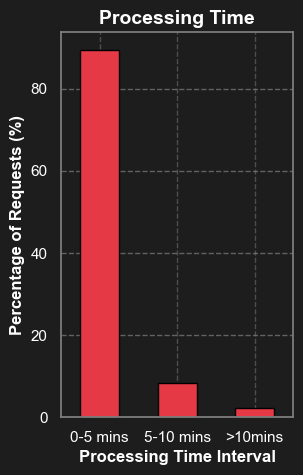

In [33]:
# Define time intervals (bins) and labels
bins = [0,5, 10, float('inf')]
labels = ['0-5 mins', '5-10 mins','>10mins']

# Categorize processing times into bins
time_analysis_df['time_category'] = pd.cut(time_analysis_df['operation_time'], bins=bins, labels=labels, right=False)

# Calculate percentage distribution
distribution = time_analysis_df['time_category'].value_counts(normalize=True) * 100

# Display the distribution
print(distribution)

# Plot the distribution as a bar chart
plt.figure(figsize=(3, 5))
distribution.sort_index().plot(kind='bar')
plt.title('Processing Time', fontsize=14)
plt.xlabel('Processing Time Interval', fontsize=12)
plt.ylabel('Percentage of Requests (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

time_category_w
45 mins-3day    51.065209
>3day           43.988514
15-45 mins       2.852908
5-15 mins        1.412560
0-5 mins         0.680808
Name: proportion, dtype: float64


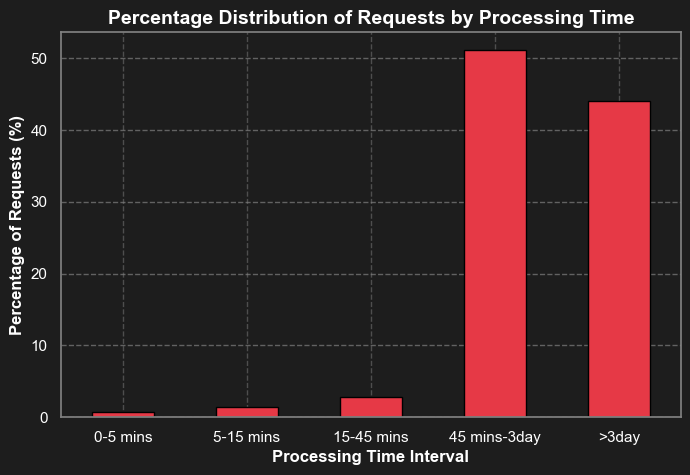

In [11]:
# Define time intervals (bins) and labels
bins = [0, 5, 15, 45, 4320, float('inf')]
labels = ['0-5 mins', '5-15 mins', '15-45 mins', '45 mins-3day','>3day']

# Categorize processing times into bins
time_analysis_df['time_category_w'] = pd.cut(time_analysis_df[main_df['team'] == 'wholesale']['global_waiting_time'], bins=bins, labels=labels, right=False)

# Calculate percentage distribution
distribution = time_analysis_df[main_df['team'] == 'wholesale']['time_category_w'].value_counts(normalize=True) * 100

# Display the distribution
print(distribution)

# Plot the distribution as a bar chart
plt.figure(figsize=(8, 5))
distribution.sort_index().plot(kind='bar')
plt.title('Percentage Distribution of Requests by Processing Time', fontsize=14)
plt.xlabel('Processing Time Interval', fontsize=12)
plt.ylabel('Percentage of Requests (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
moderators_req_count_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('moderator').size().rename('req_count_r')
moderators_req_count_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('moderator').size().rename('req_count_w')

moderators_req = pd.concat([moderators_req_count_r, moderators_req_count_w], axis=1)


In [13]:
incoming_counts_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('request_hour').size().rename('req_r_requests')
start_start_counts_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('start_hour').size().rename('s_r_processing_requests')
finish_start_counts_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('finish_hour').size().rename('f_r_processing_requests')

incoming_counts_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('request_hour').size().rename('req_w_requests')
start_start_counts_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('start_hour').size().rename('s_w_processing_requests')
finish_start_counts_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('finish_hour').size().rename('f_w_processing_requests')

# Combine all counts into a single DataFrame
hourly_stats = pd.concat([incoming_counts_r, start_start_counts_r, finish_start_counts_r,
                          incoming_counts_w, start_start_counts_w, finish_start_counts_w], axis=1).fillna(0)

# Reset the index for better readability
hourly_stats.reset_index(inplace=True)
hourly_stats.rename(columns={'index': 'hour'}, inplace=True)

hourly_stats

hour  req_r_requests  s_r_processing_requests  f_r_processing_requests  \
0      0              78                      0.0                      0.0   
1      1              31                      0.0                      0.0   
2      2              29                      0.0                      0.0   
3      3              63                      0.0                      0.0   
4      4             109                      0.0                      0.0   
5      5             271                      0.0                      0.0   
6      6             420                      2.0                      0.0   
7      7             741                   1474.0                   1457.0   
8      8             937                    617.0                    578.0   
9      9            1194                   1379.0                   1411.0   
10    10            1159                    713.0                    701.0   
11    11            1391                   1590.0                   1589.0   
12    12            1154                    869.0                    870.0   
13    13            1154                   1814.0                   1819.0   
14    14             913                    779.0                    793.0   
15    15             781                    918.0                    911.0   
16    16             567                    651.0                    661.0   
17    17             605                    709.0                    713.0   
18    18             600                    494.0                    488.0   
19    19             629                    792.0                    798.0   
20    20             518                    552.0                    562.0   
21    21             323                    473.0                    472.0   
22    22             221                    198.0                    201.0   
23    23             137                      1.0                      1.0   

    req_w_requests  s_w_processing_requests  f_w_processing_requests  
0              509                      7.0                      7.0  
1             1476                      0.0                      0.0  
2             1789                      0.0                      0.0  
3             1847                      0.0                      0.0  
4              949                      0.0                      0.0  
5             1179                      0.0                      0.0  
6             1619                      1.0                      0.0  
7             1831                   2015.0                   1916.0  
8             2449                   2350.0                   2386.0  
9             1746                   2064.0                   2024.0  
10             856                   2225.0                   2260.0  
11             778                   1813.0                   1804.0  
12             771                   1770.0                   1797.0  
13             840                   1115.0                   1112.0  
14             827                   1366.0                   1391.0  
15             729                    949.0                    932.0  
16             422                   1138.0                   1167.0  
17             167                    977.0                    957.0  
18              97                   1011.0                   1036.0  
19              92                    685.0                    670.0  
20             145                    875.0                    885.0  
21             126                    521.0                    522.0  
22             133                    706.0                    711.0  
23             215                      4.0                     15.0

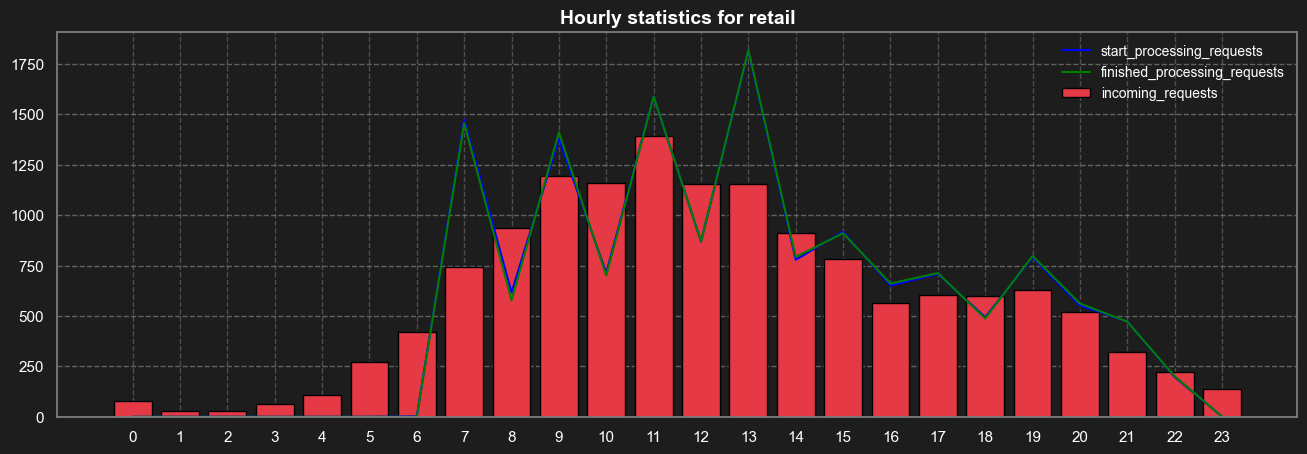

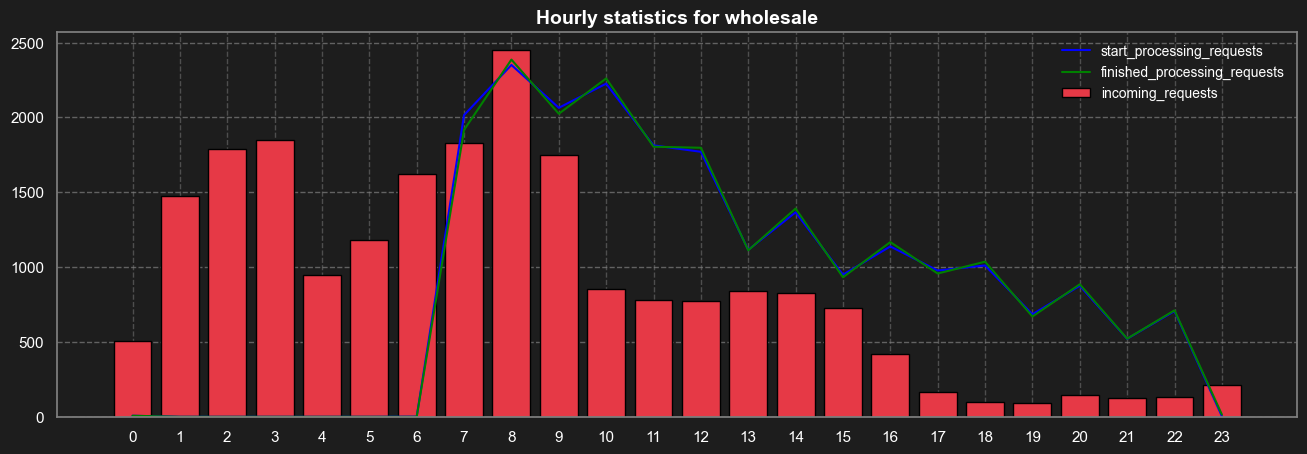

In [14]:
plt.figure(figsize=(16,5))
plt.xticks(range(0, 24))
plt.bar(hourly_stats['hour'], hourly_stats['req_r_requests'],label='incoming_requests')
plt.plot(hourly_stats['hour'], hourly_stats['s_r_processing_requests'],color='blue',label='start_processing_requests')
plt.plot(hourly_stats['hour'], hourly_stats['f_r_processing_requests'],color='green',label='finished_processing_requests')
plt.title('Hourly statistics for retail')
plt.legend()  # Show the legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(16,5))
plt.xticks(range(0, 24))
plt.bar(hourly_stats['hour'], hourly_stats['req_w_requests'],label='incoming_requests')
plt.plot(hourly_stats['hour'], hourly_stats['s_w_processing_requests'],color='blue',label='start_processing_requests')
plt.plot(hourly_stats['hour'], hourly_stats['f_w_processing_requests'],color='green',label='finished_processing_requests')
plt.title('Hourly statistics for wholesale')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()  # Show the legend
plt.show()

Hypothesis #1 - requests are receiving in the night, so they got proceed only in work time
is TRUE

Hypothesis #2 - requests have avalanche effect after each night, so some of them are not proceed through months?

Date-based analysis

In [15]:
time_analysis_df.head(5)

moderator  id_request        request_time          start_time  \
0        165      159660 2020-09-24 07:01:16 2020-10-01 16:00:31   
1        178      160116 2020-09-24 22:32:15 2020-10-01 13:21:42   
2        187      160178 2020-09-25 02:58:13 2020-10-02 11:37:16   
3        178      160306 2020-09-25 09:44:12 2020-10-02 07:23:09   
4        178      163042 2020-09-30 15:56:08 2020-10-02 07:37:33   

          finish_time       team  time_to_start_operation  operation_time  \
0 2020-10-01 16:02:02     retail             10619.250000        1.516667   
1 2020-10-01 13:21:43     retail              9529.450000        0.016667   
2 2020-10-02 11:41:56  wholesale             10599.050000        4.666667   
3 2020-10-02 07:25:33     retail              9938.950000        2.400000   
4 2020-10-02 07:47:57     retail              2381.416667       10.400000   

   global_waiting_time  request_hour request_date  start_hour  start_date  \
0         10620.766667             7   2020-09-24          16  2020-10-01   
1          9529.466667            22   2020-09-24          13  2020-10-01   
2         10603.716667             2   2020-09-25          11  2020-10-02   
3          9941.350000             9   2020-09-25           7  2020-10-02   
4          2391.816667            15   2020-09-30           7  2020-10-02   

   finish_hour finish_date time_category_w  
0           16  2020-10-01             NaN  
1           13  2020-10-01             NaN  
2           11  2020-10-02           >3day  
3            7  2020-10-02             NaN  
4            7  2020-10-02             NaN

In [16]:
incoming_counts_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('request_date').size().rename('req_r_requests')
finish_start_counts_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('finish_date').size().rename('f_r_processing_requests')
waiting_count_r = (incoming_counts_r - finish_start_counts_r).rename('wait_r_requests')

incoming_counts_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('request_date').size().rename('req_w_requests')
finish_start_counts_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('finish_date').size().rename('f_w_processing_requests')
waiting_count_w = (incoming_counts_w - finish_start_counts_w).rename('wait_w_requests')


number_of_r_moderators = time_analysis_df[time_analysis_df['team']=='retail'].groupby('finish_date').agg(num_of_r_moderators=('moderator','nunique'))
number_of_w_moderators = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('finish_date').agg(num_of_w_moderators=('moderator','nunique'))


avg_time_to_start_operation_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('finish_date').agg(avg_time_to_start_operation_r=('time_to_start_operation','mean'))
avg_operation_time_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('finish_date').agg(avg_operation_time_r=('operation_time','mean'))
avg_global_waiting_time_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('finish_date').agg(avg_global_waiting_time_r=('global_waiting_time','mean'))

avg_time_to_start_operation_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('finish_date').agg(avg_time_to_start_operation_w=('time_to_start_operation','mean'))
avg_operation_time_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('finish_date').agg(avg_operation_time_w=('operation_time','mean'))
avg_global_waiting_time_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('finish_date').agg(avg_global_waiting_time_w=('global_waiting_time','mean'))

sum_operation_time_w = time_analysis_df[time_analysis_df['team']=='wholesale'].groupby('finish_date').agg(sum_operation_time_w=('operation_time','sum'))
sum_operation_time_r = time_analysis_df[time_analysis_df['team']=='retail'].groupby('finish_date').agg(sum_operation_time_r=('operation_time','sum'))


# Combine all counts into a single DataFrame
daily_stats = pd.concat([incoming_counts_r, waiting_count_r,finish_start_counts_r,
                          incoming_counts_w, waiting_count_w, finish_start_counts_w,number_of_r_moderators,number_of_w_moderators,
                         avg_time_to_start_operation_r,avg_operation_time_r, avg_global_waiting_time_r,
                         avg_time_to_start_operation_w,avg_operation_time_w, avg_global_waiting_time_w,
                         sum_operation_time_w,sum_operation_time_r], axis=1).fillna(0)

# Reset the index for better readability
daily_stats.reset_index(inplace=True)
daily_stats.rename(columns={'index': 'date'}, inplace=True)

# Calculate cumulative sums
daily_stats["cumulative_income_r"] = daily_stats["req_r_requests"].cumsum()
daily_stats["cumulative_finish_r"] = daily_stats["f_r_processing_requests"].cumsum()
daily_stats["waiting_requests_r"] = daily_stats["cumulative_income_r"] - daily_stats["cumulative_finish_r"]

# Calculate cumulative sums
daily_stats["cumulative_income_w"] = daily_stats["req_w_requests"].cumsum()
daily_stats["cumulative_finish_w"] = daily_stats["f_w_processing_requests"].cumsum()

# Calculate waiting requests
daily_stats["waiting_requests_w"] = daily_stats["cumulative_income_w"] - daily_stats["cumulative_finish_w"]

print(f'Number of all days: {len(daily_stats['date'])}')
print(f'Number of work days: {len(daily_stats['date']) * 5/7}')
daily_stats

Number of all days: 95
Number of work days: 67.85714285714286


date  req_r_requests  wait_r_requests  f_r_processing_requests  \
0   2020-09-24               2              0.0                      0.0   
1   2020-09-25               1              0.0                      0.0   
2   2020-09-30               1              0.0                      0.0   
3   2020-10-01             218             14.0                    204.0   
4   2020-10-02             185              6.0                    179.0   
..         ...             ...              ...                      ...   
90  2020-12-27             182              0.0                    182.0   
91  2020-12-28             131              5.0                    126.0   
92  2020-12-29             179             -2.0                    181.0   
93  2020-12-30             166             -3.0                    169.0   
94  2020-12-31             268            -10.0                    278.0   

    req_w_requests  wait_w_requests  f_w_processing_requests  \
0              0.0              0.0                      0.0   
1              1.0              0.0                      0.0   
2              0.0              0.0                      0.0   
3             80.0              2.0                     78.0   
4             60.0              1.0                     59.0   
..             ...              ...                      ...   
90           599.0             35.0                    564.0   
91           441.0             56.0                    385.0   
92           109.0           -502.0                    611.0   
93            19.0           -513.0                    532.0   
94             0.0              0.0                    446.0   

    num_of_r_moderators  num_of_w_moderators  avg_time_to_start_operation_r  \
0                   0.0                  0.0                       0.000000   
1                   0.0                  0.0                       0.000000   
2                   0.0                  0.0                       0.000000   
3                  10.0                  8.0                     141.248121   
4                   7.0                  8.0                     168.641155   
..                  ...                  ...                            ...   
90                  6.0                  8.0                      89.238736   
91                  4.0                  6.0                     812.400000   
92                  6.0                  6.0                      70.474217   
93                  7.0                  9.0                    1383.582742   
94                  7.0                  8.0                    1138.222122   

    ...  avg_operation_time_w  avg_global_waiting_time_w  \
0   ...              0.000000                   0.000000   
1   ...              0.000000                   0.000000   
2   ...              0.000000                   0.000000   
3   ...              3.150000                  96.128419   
4   ...              3.751977                 290.519774   
..  ...                   ...                        ...   
90  ...              2.403280                4933.847074   
91  ...              2.361515                4534.016753   
92  ...              1.769422                4441.579705   
93  ...              2.703571                4337.416573   
94  ...              2.367676                4480.967713   

    sum_operation_time_w  sum_operation_time_r  cumulative_income_r  \
0               0.000000              0.000000                    2   
1               0.000000              0.000000                    3   
2               0.000000              0.000000                    4   
3             245.700000            377.550000                  222   
4             221.366667            388.650000                  407   
..                   ...                   ...                  ...   
90           1355.450000            354.166667                13281   
91            909.183333            224.700000                13412   
92           1081.1

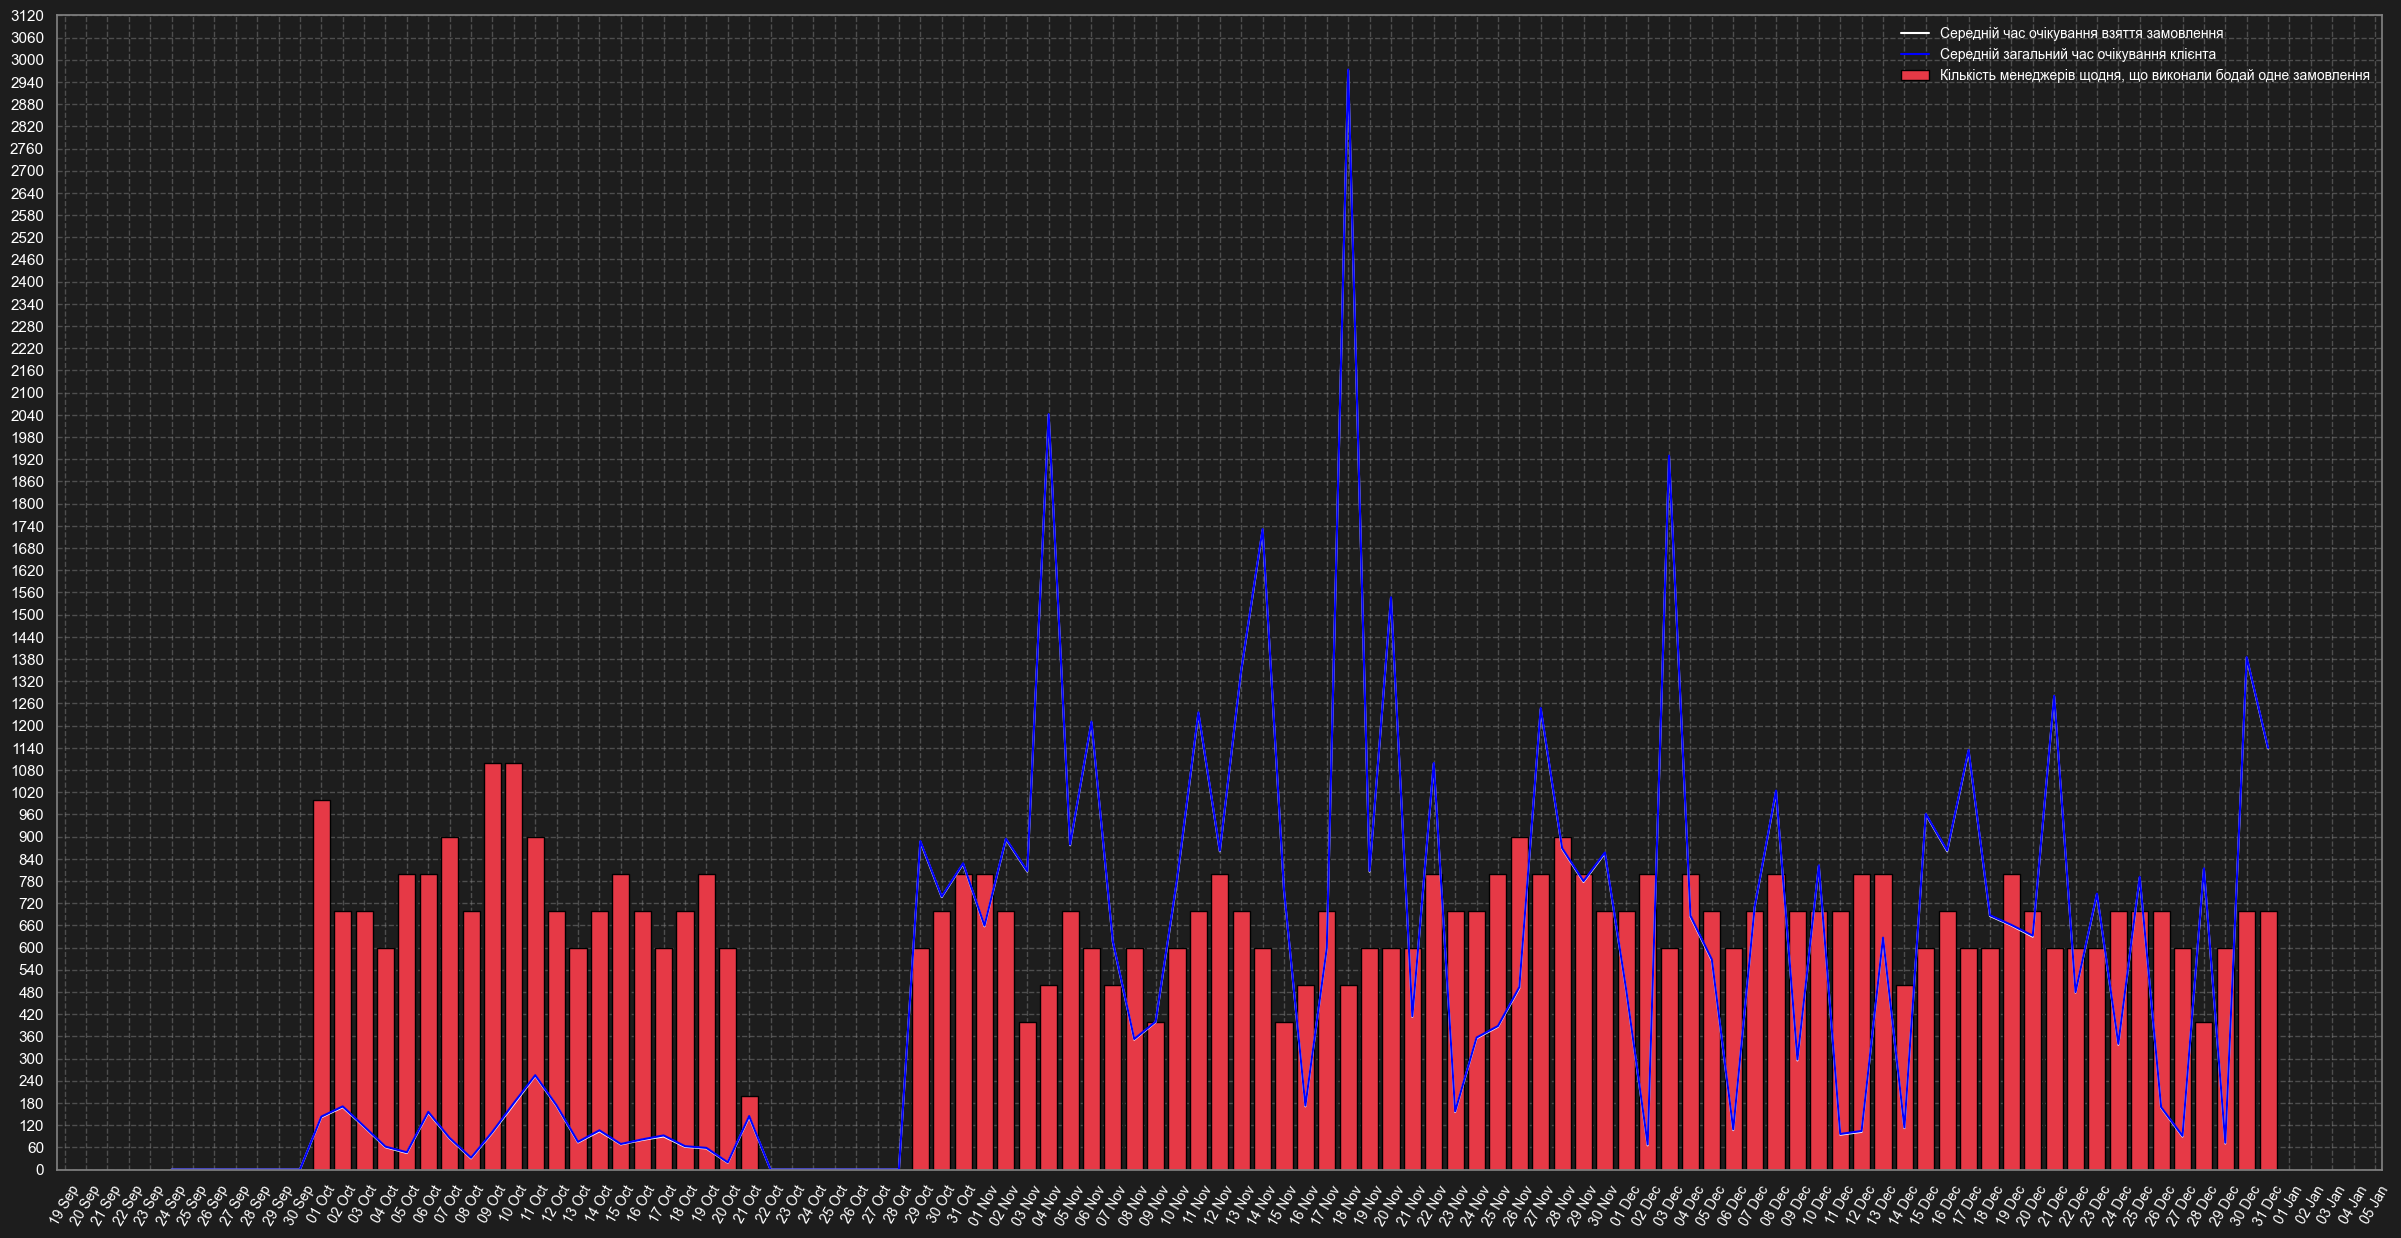

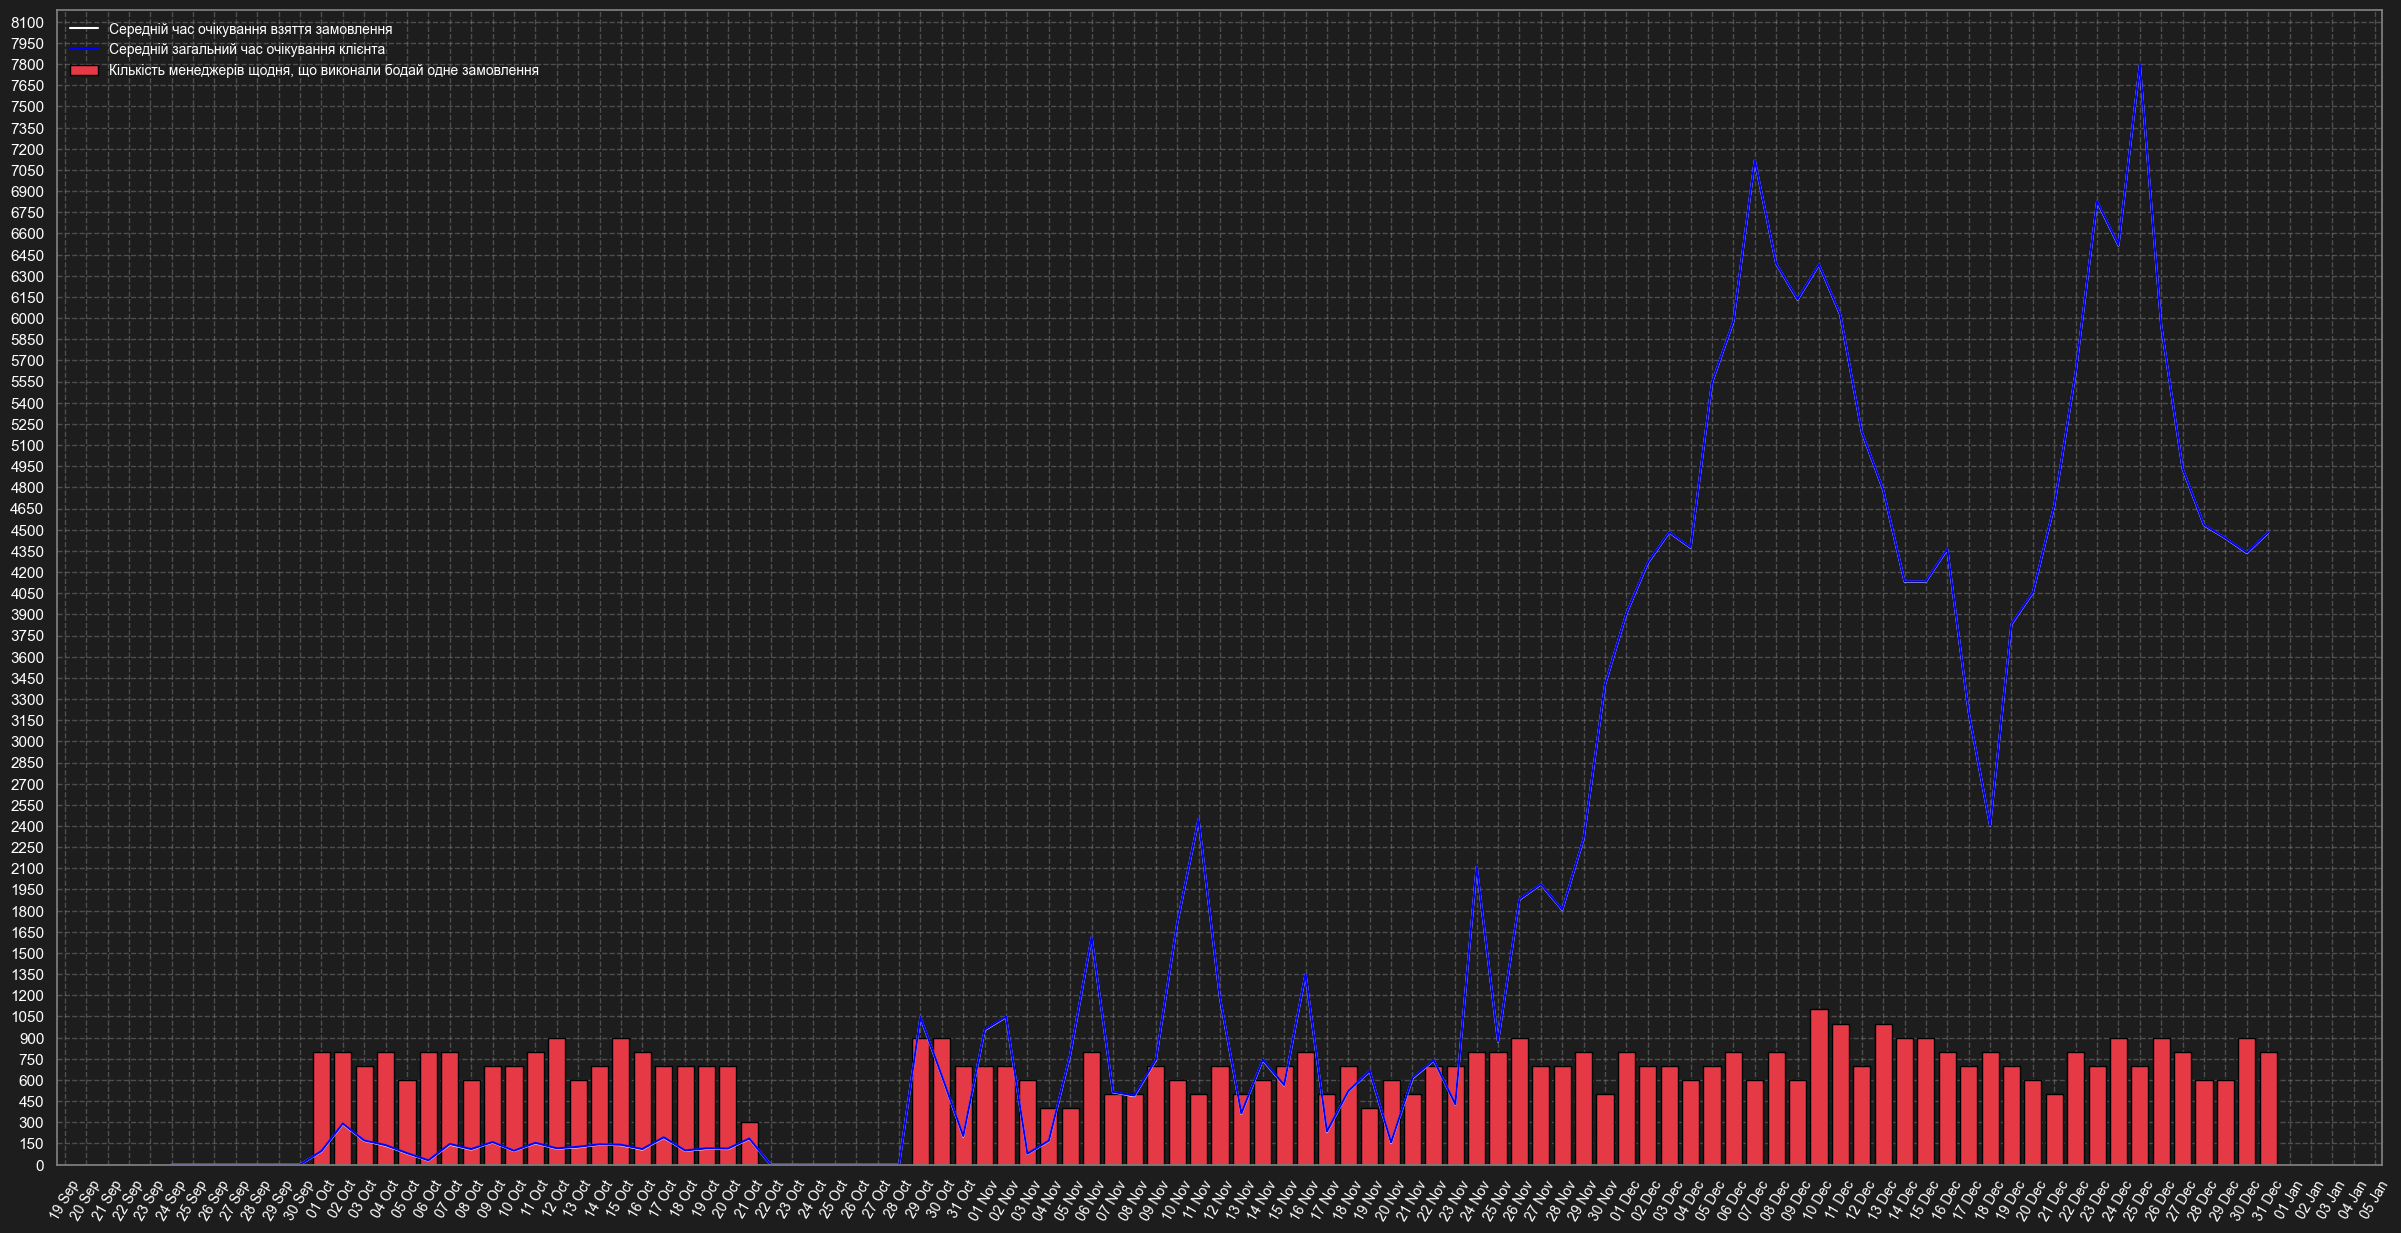

In [17]:
fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot()
ax1.yaxis.set_major_locator(MaxNLocator(nbins=60))
ax1.bar(daily_stats['date'], daily_stats['num_of_r_moderators']*100,label='Кількість менеджерів щодня, що виконали бодай одне замовлення')
ax1.plot(daily_stats['date'], daily_stats['avg_time_to_start_operation_r'] ,color='white',label='Середній час очікування взяття замовлення')
ax1.plot(daily_stats['date'], daily_stats['avg_global_waiting_time_r'] ,color='blue',label='Середній загальний час очікування клієнта')
ax1.tick_params(axis='x',labelrotation=60, labelsize=10)
ax1.tick_params(axis='y')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as "Month Year"
ax1.legend()  # Show the legend
plt.show()

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot()
ax1.yaxis.set_major_locator(MaxNLocator(nbins=60))
ax1.bar(daily_stats['date'], daily_stats['num_of_w_moderators']*100,label='Кількість менеджерів щодня, що виконали бодай одне замовлення')
ax1.plot(daily_stats['date'], daily_stats['avg_time_to_start_operation_w'] ,color='white',label='Середній час очікування взяття замовлення')
ax1.plot(daily_stats['date'], daily_stats['avg_global_waiting_time_w'] ,color='blue',label='Середній загальний час очікування клієнта')
ax1.tick_params(axis='x',labelrotation=60, labelsize=10)
ax1.tick_params(axis='y')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as "Month Year"
ax1.legend()  # Show the legend
plt.show()

DATE VS. WORKERS AND FINISHED REQUESTS

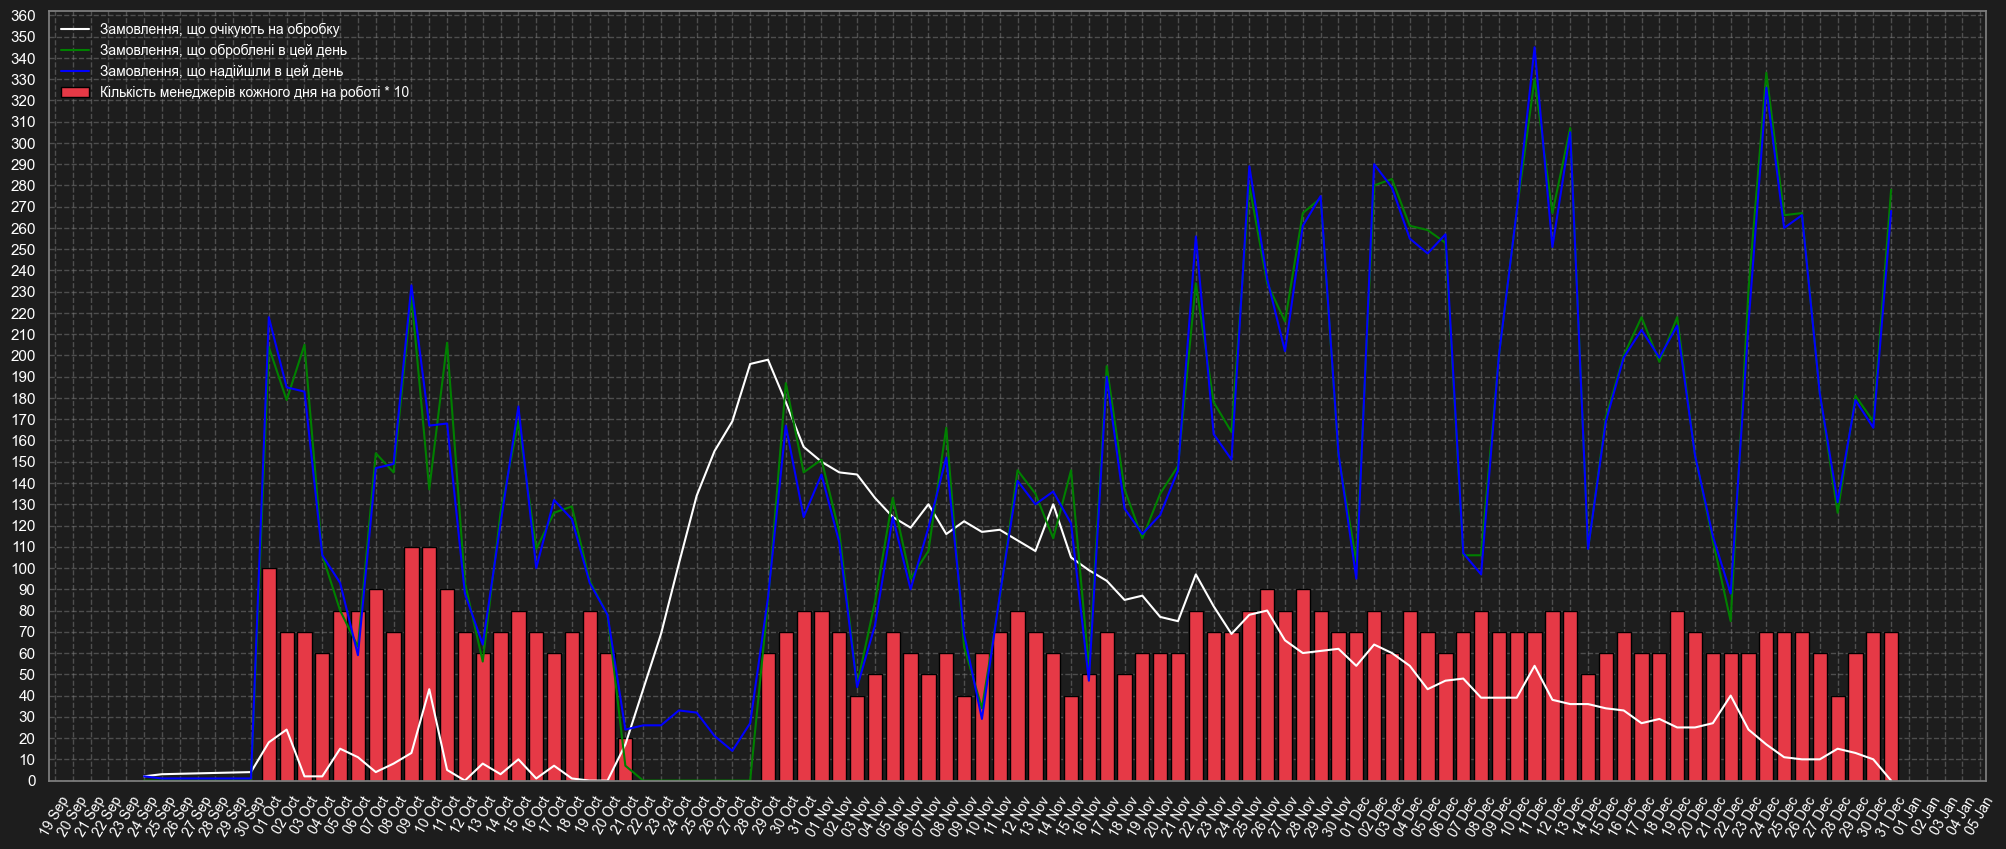

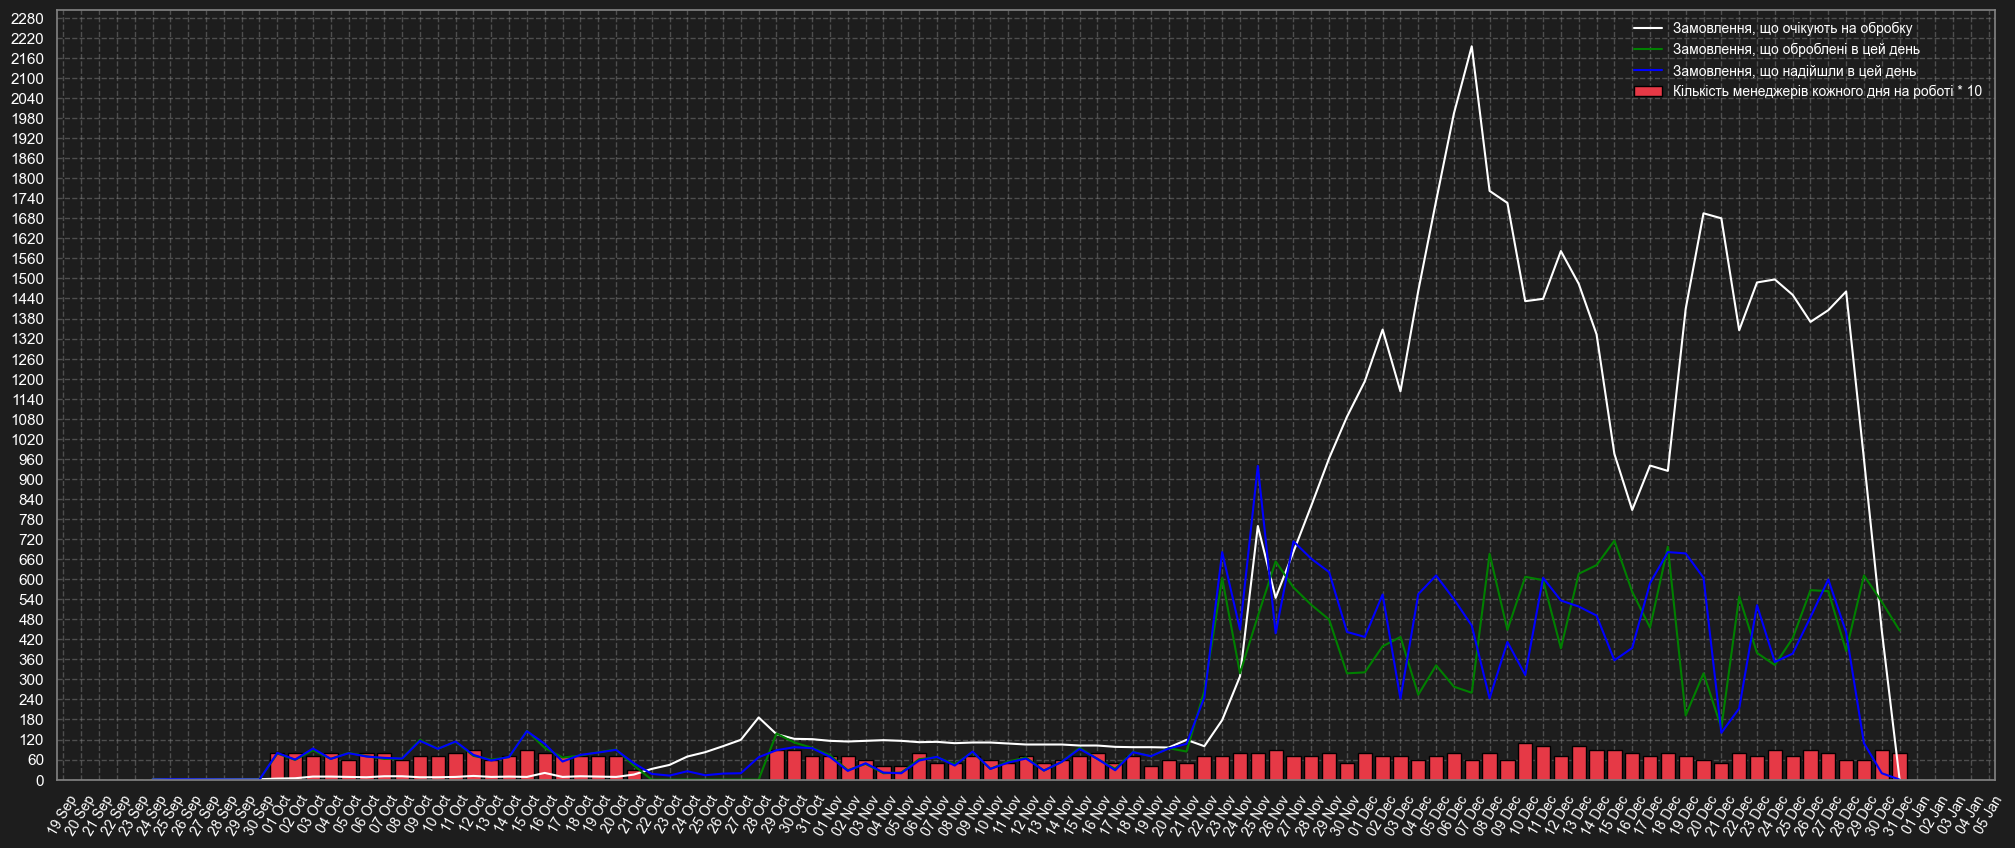

In [18]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot()
ax1.yaxis.set_major_locator(MaxNLocator(nbins=40))
ax1.bar(daily_stats['date'], daily_stats['num_of_r_moderators']*10,label='Кількість менеджерів кожного дня на роботі * 10')
ax1.plot(daily_stats['date'], daily_stats['waiting_requests_r'],color='white',label='Замовлення, що очікують на обробку')
ax1.plot(daily_stats['date'], daily_stats['f_r_processing_requests'],color='green',label='Замовлення, що оброблені в цей день')
ax1.plot(daily_stats['date'], daily_stats['req_r_requests'],color='blue',label='Замовлення, що надійшли в цей день')
ax1.tick_params(axis='x',labelrotation=60, labelsize=10)
ax1.tick_params(axis='y')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as "Month Year"
ax1.legend()  # Show the legend
plt.show()

fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot()
ax1.yaxis.set_major_locator(MaxNLocator(nbins=40))
ax1.bar(daily_stats['date'], daily_stats['num_of_w_moderators']*10,label='Кількість менеджерів кожного дня на роботі * 10')
ax1.plot(daily_stats['date'], daily_stats['waiting_requests_w'] ,color='white',label='Замовлення, що очікують на обробку')
ax1.plot(daily_stats['date'], daily_stats['f_w_processing_requests'],color='green',label='Замовлення, що оброблені в цей день')
ax1.plot(daily_stats['date'], daily_stats['req_w_requests'],color='blue',label='Замовлення, що надійшли в цей день')
ax1.tick_params(axis='x',labelrotation=60, labelsize=10)
ax1.tick_params(axis='y')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as "Month Year"
ax1.legend()  # Show the legend
plt.show()

In [19]:
daily_stats

date  req_r_requests  wait_r_requests  f_r_processing_requests  \
0   2020-09-24               2              0.0                      0.0   
1   2020-09-25               1              0.0                      0.0   
2   2020-09-30               1              0.0                      0.0   
3   2020-10-01             218             14.0                    204.0   
4   2020-10-02             185              6.0                    179.0   
..         ...             ...              ...                      ...   
90  2020-12-27             182              0.0                    182.0   
91  2020-12-28             131              5.0                    126.0   
92  2020-12-29             179             -2.0                    181.0   
93  2020-12-30             166             -3.0                    169.0   
94  2020-12-31             268            -10.0                    278.0   

    req_w_requests  wait_w_requests  f_w_processing_requests  \
0              0.0              0.0                      0.0   
1              1.0              0.0                      0.0   
2              0.0              0.0                      0.0   
3             80.0              2.0                     78.0   
4             60.0              1.0                     59.0   
..             ...              ...                      ...   
90           599.0             35.0                    564.0   
91           441.0             56.0                    385.0   
92           109.0           -502.0                    611.0   
93            19.0           -513.0                    532.0   
94             0.0              0.0                    446.0   

    num_of_r_moderators  num_of_w_moderators  avg_time_to_start_operation_r  \
0                   0.0                  0.0                       0.000000   
1                   0.0                  0.0                       0.000000   
2                   0.0                  0.0                       0.000000   
3                  10.0                  8.0                     141.248121   
4                   7.0                  8.0                     168.641155   
..                  ...                  ...                            ...   
90                  6.0                  8.0                      89.238736   
91                  4.0                  6.0                     812.400000   
92                  6.0                  6.0                      70.474217   
93                  7.0                  9.0                    1383.582742   
94                  7.0                  8.0                    1138.222122   

    ...  avg_operation_time_w  avg_global_waiting_time_w  \
0   ...              0.000000                   0.000000   
1   ...              0.000000                   0.000000   
2   ...              0.000000                   0.000000   
3   ...              3.150000                  96.128419   
4   ...              3.751977                 290.519774   
..  ...                   ...                        ...   
90  ...              2.403280                4933.847074   
91  ...              2.361515                4534.016753   
92  ...              1.769422                4441.579705   
93  ...              2.703571                4337.416573   
94  ...              2.367676                4480.967713   

    sum_operation_time_w  sum_operation_time_r  cumulative_income_r  \
0               0.000000              0.000000                    2   
1               0.000000              0.000000                    3   
2               0.000000              0.000000                    4   
3             245.700000            377.550000                  222   
4             221.366667            388.650000                  407   
..                   ...                   ...                  ...   
90           1355.450000            354.166667                13281   
91            909.183333            224.700000                13412   
92           1081.1

 DATE VS. DIFFERENT STAGES OF REQUESTS and WORK TIME

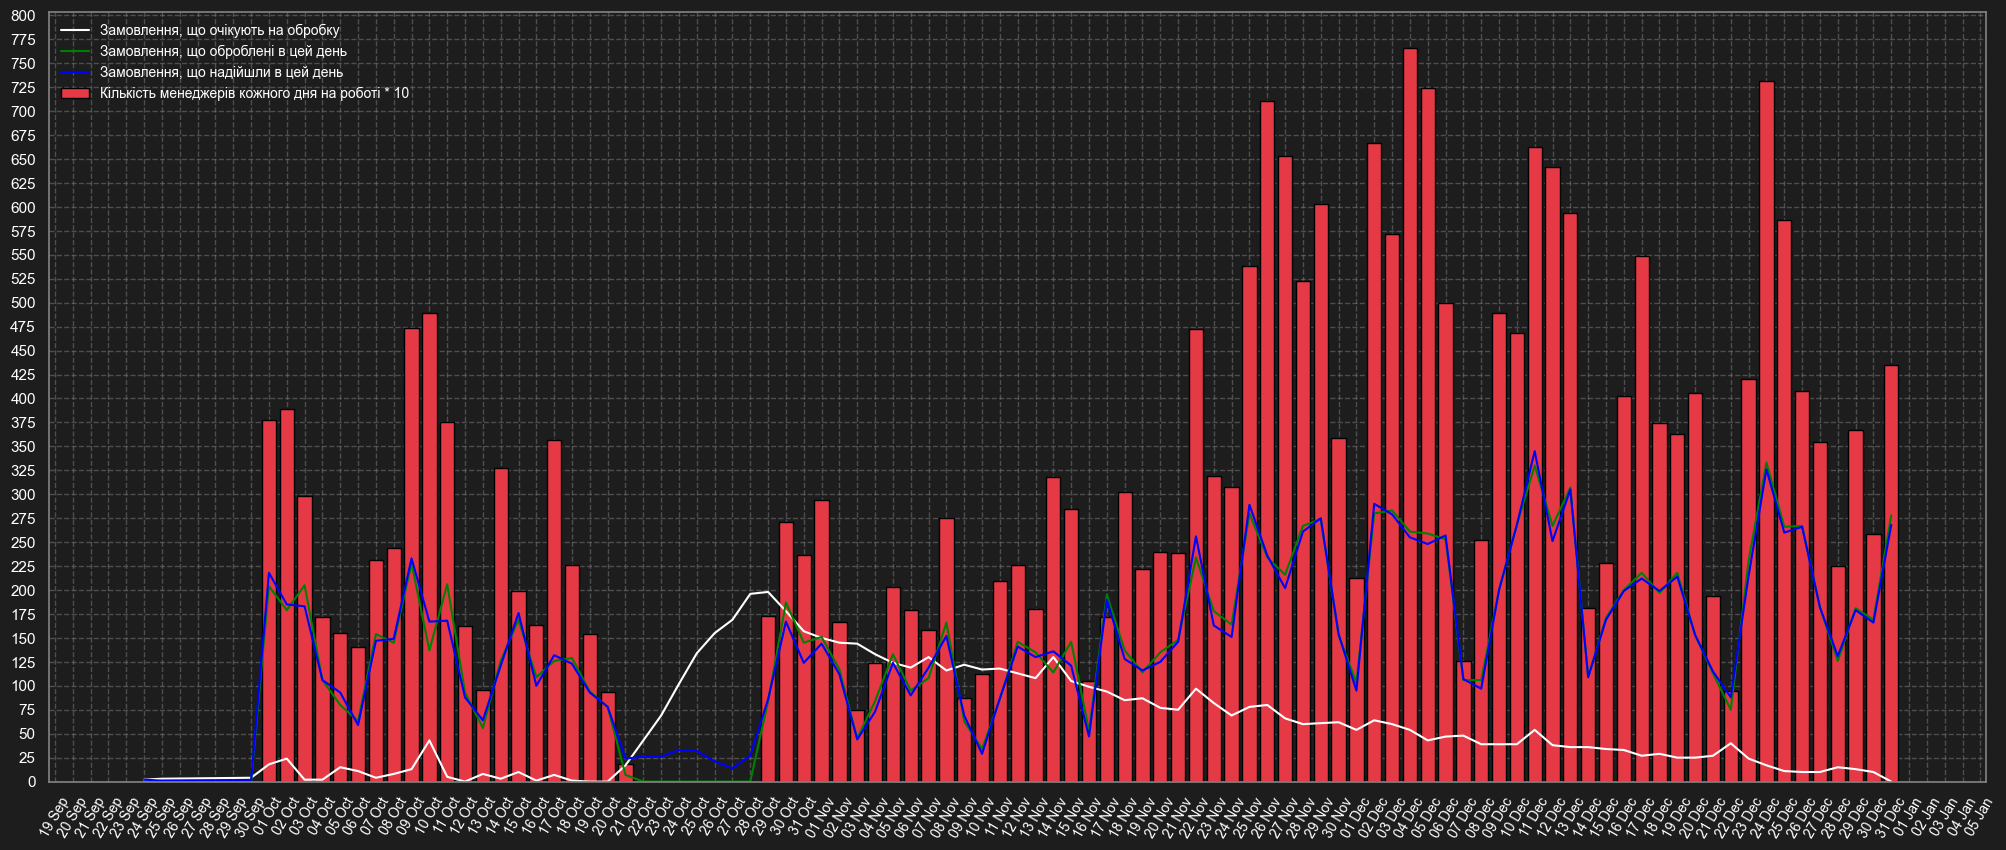

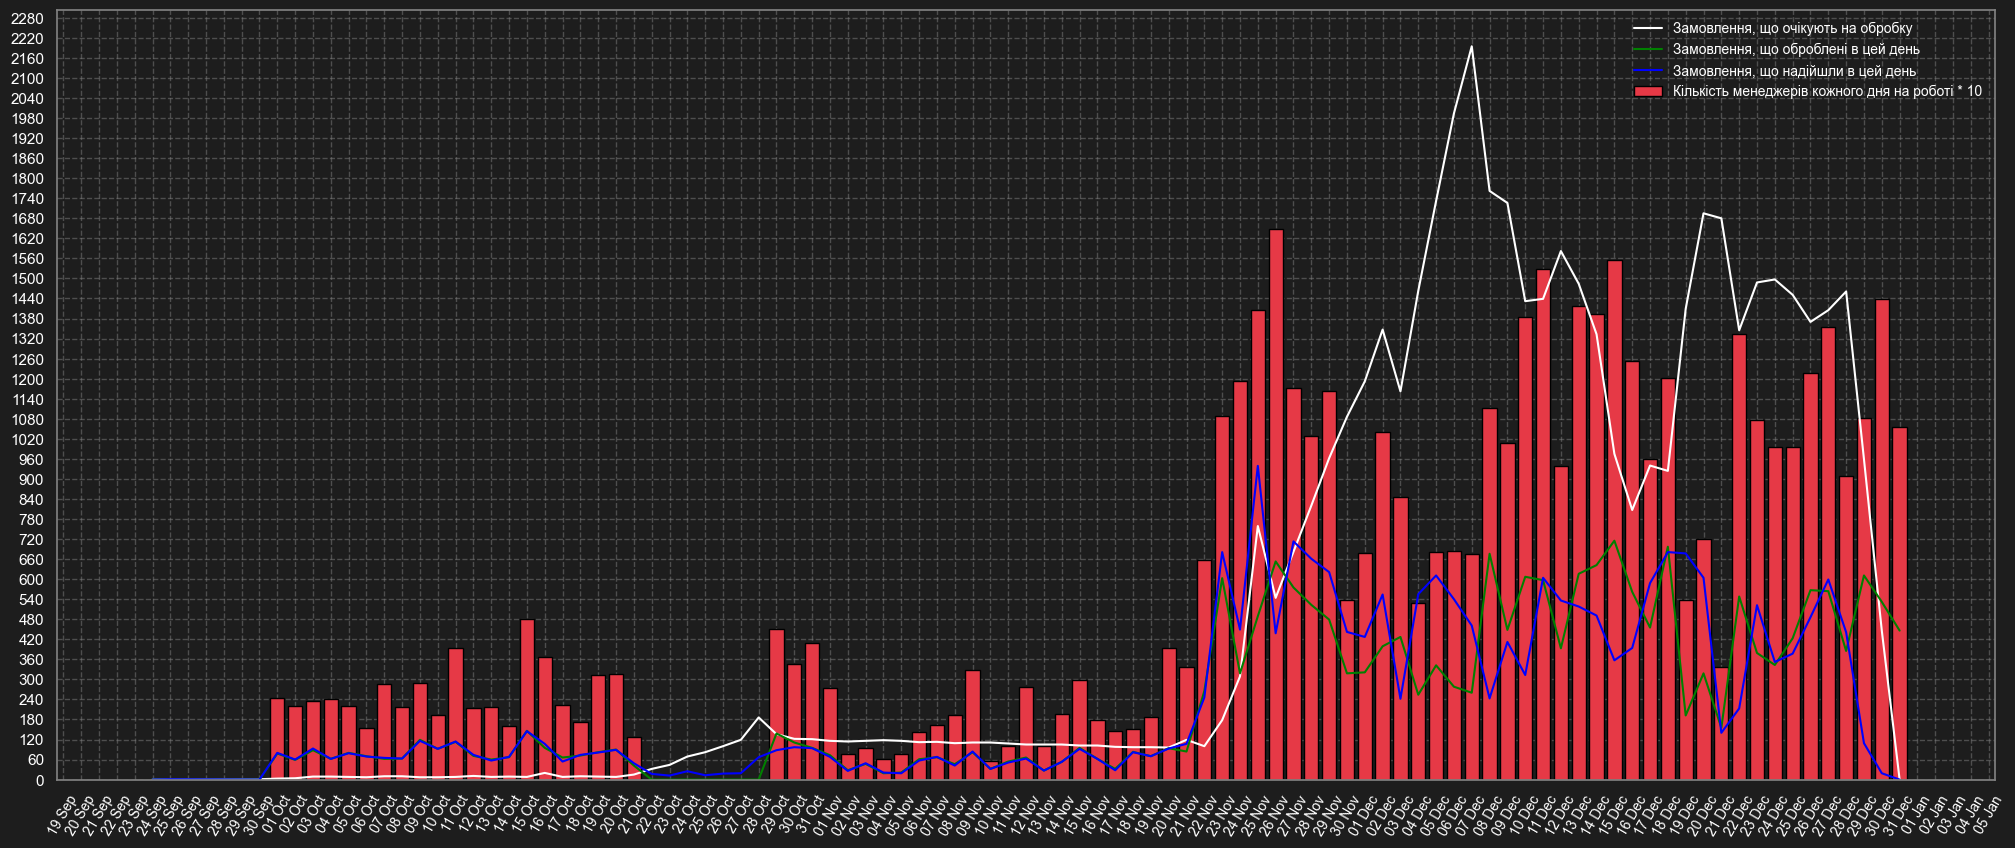

In [20]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot()
ax1.yaxis.set_major_locator(MaxNLocator(nbins=40))
ax1.bar(daily_stats['date'], daily_stats['sum_operation_time_r'],label='Кількість менеджерів кожного дня на роботі * 10')
ax1.plot(daily_stats['date'], daily_stats['waiting_requests_r'],color='white',label='Замовлення, що очікують на обробку')
ax1.plot(daily_stats['date'], daily_stats['f_r_processing_requests'],color='green',label='Замовлення, що оброблені в цей день')
ax1.plot(daily_stats['date'], daily_stats['req_r_requests'],color='blue',label='Замовлення, що надійшли в цей день')
ax1.tick_params(axis='x',labelrotation=60, labelsize=10)
ax1.tick_params(axis='y')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as "Month Year"
ax1.legend()  # Show the legend
plt.show()

fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot()
ax1.yaxis.set_major_locator(MaxNLocator(nbins=40))
ax1.bar(daily_stats['date'], daily_stats['sum_operation_time_w'],label='Кількість менеджерів кожного дня на роботі * 10')
ax1.plot(daily_stats['date'], daily_stats['waiting_requests_w'] ,color='white',label='Замовлення, що очікують на обробку')
ax1.plot(daily_stats['date'], daily_stats['f_w_processing_requests'],color='green',label='Замовлення, що оброблені в цей день')
ax1.plot(daily_stats['date'], daily_stats['req_w_requests'],color='blue',label='Замовлення, що надійшли в цей день')
ax1.tick_params(axis='x',labelrotation=60, labelsize=10)
ax1.tick_params(axis='y')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as "Month Year"
ax1.legend()  # Show the legend
plt.show()

DATE VS. REQUESTS ON DIFFERENT STAGES

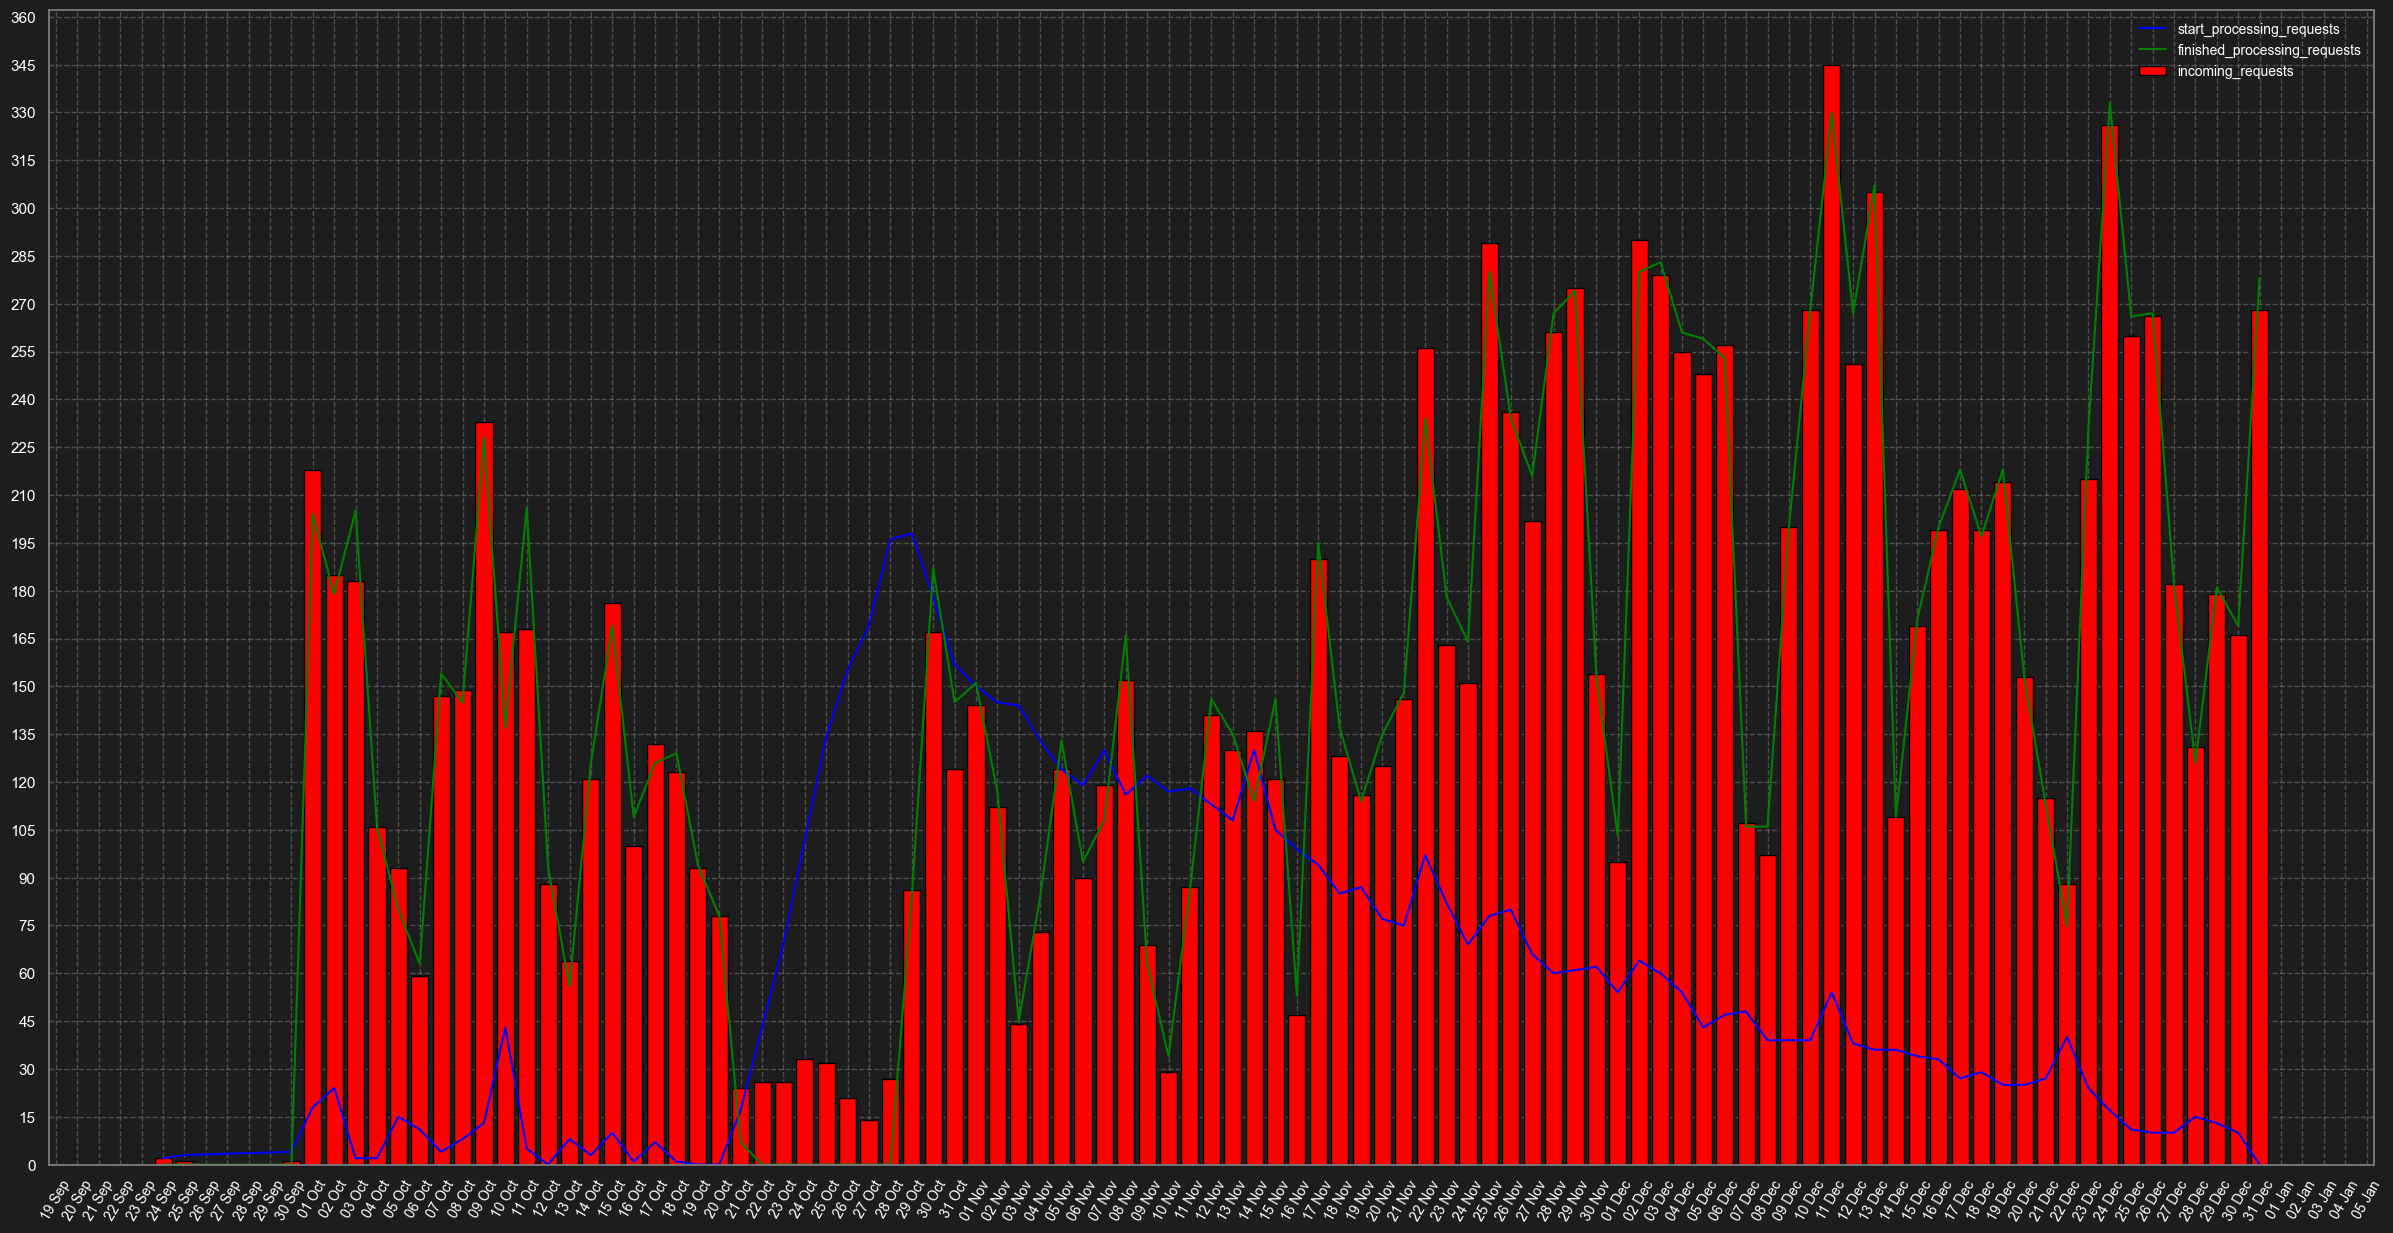

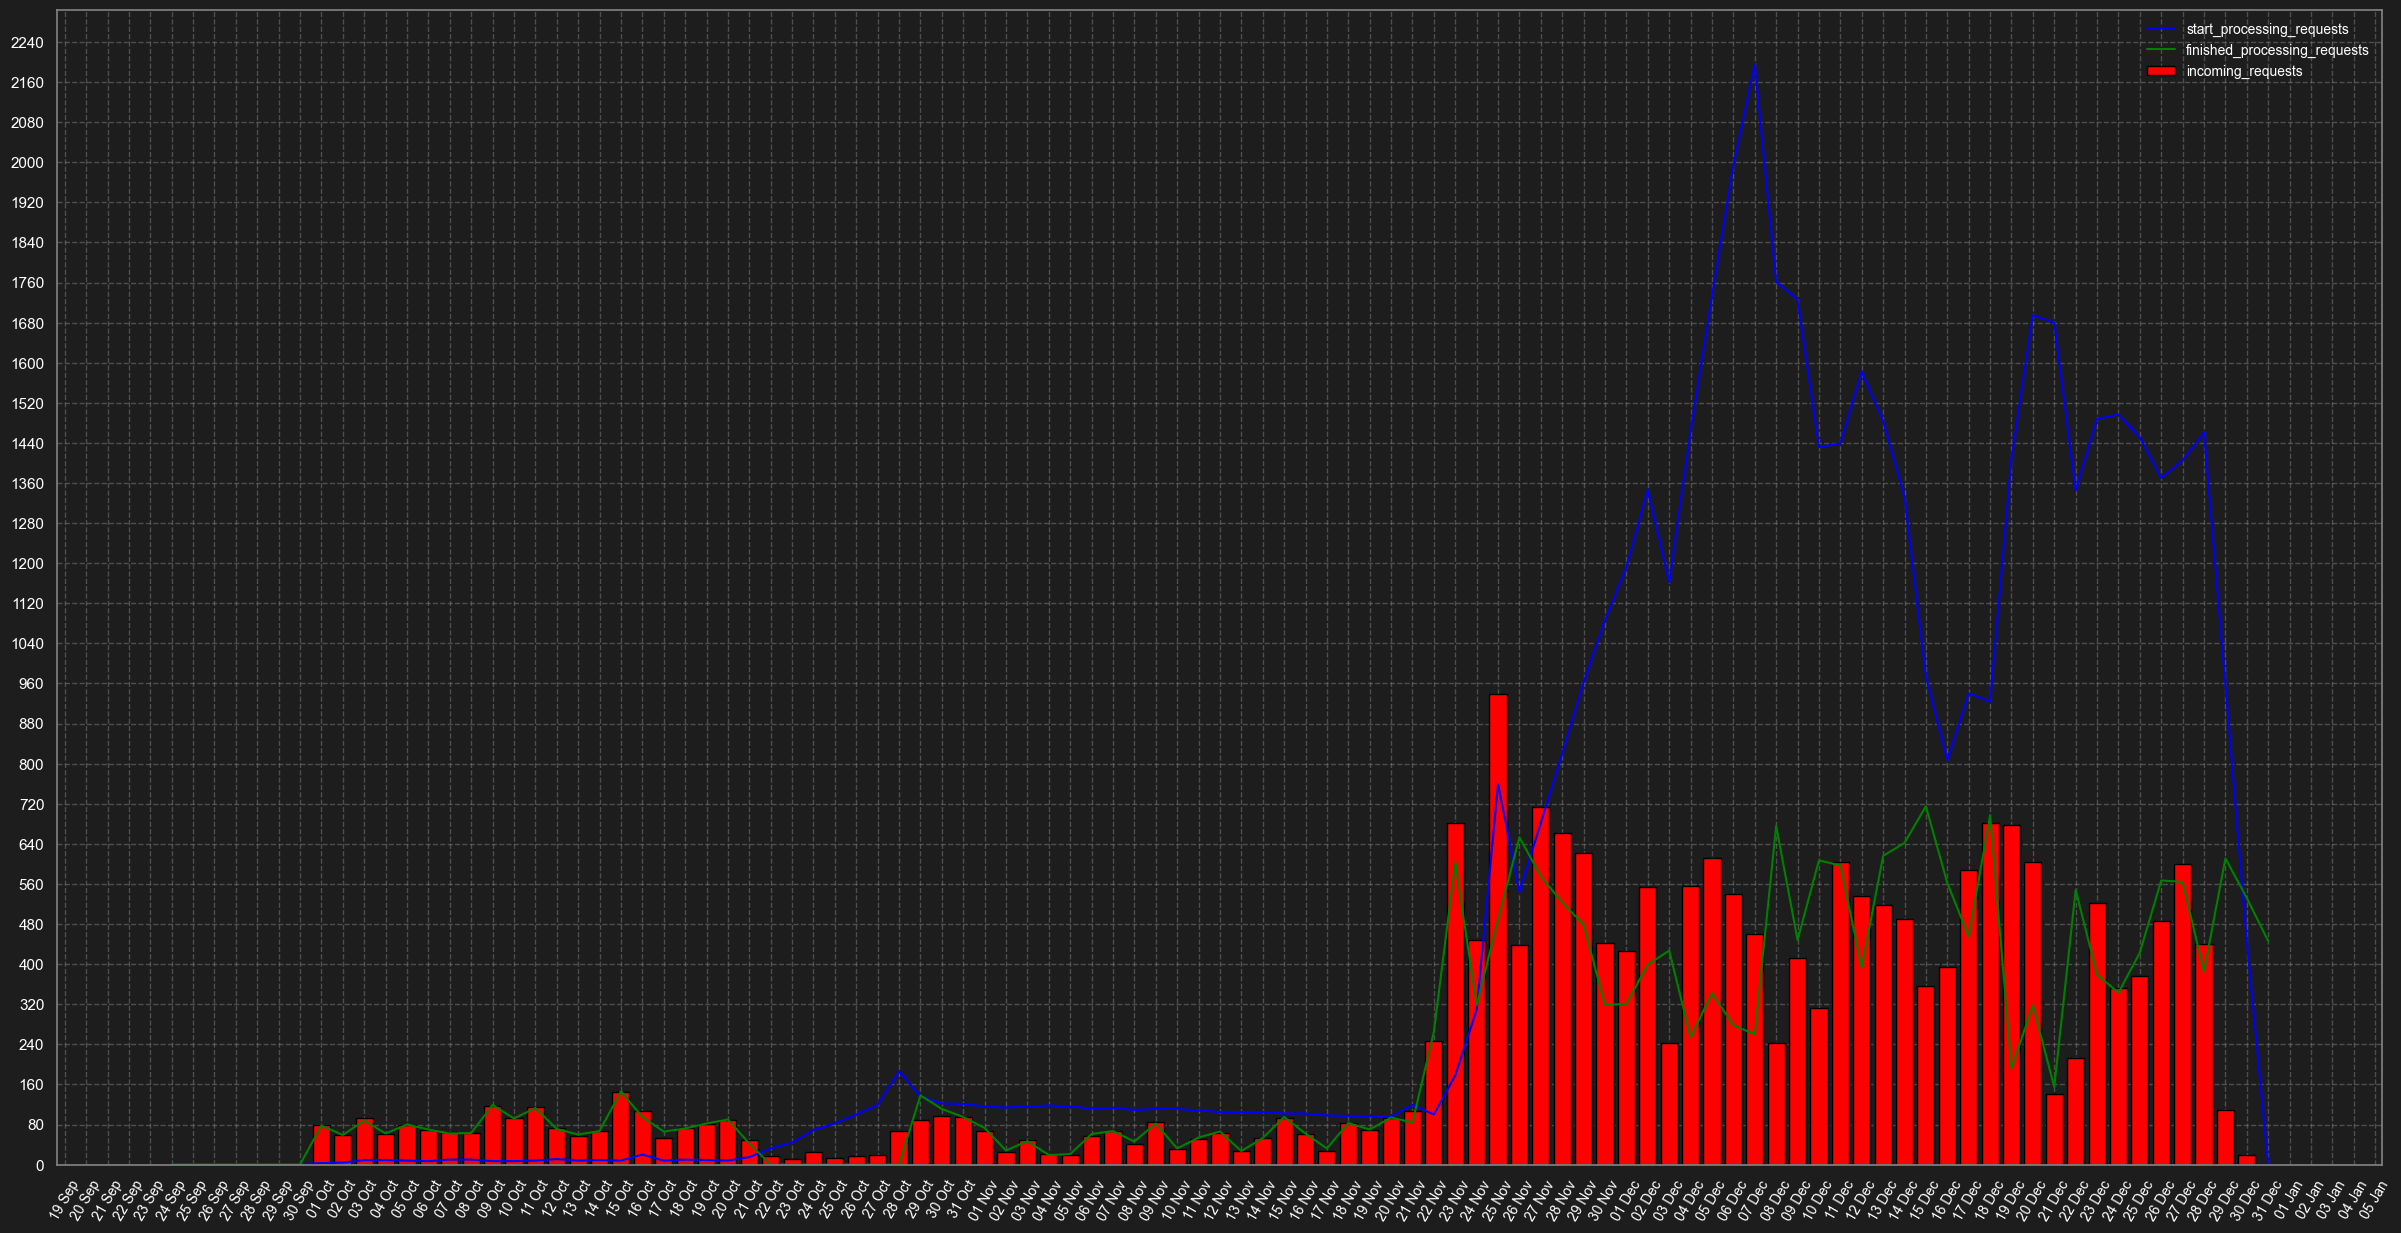

In [21]:

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot()
ax1.yaxis.set_major_locator(MaxNLocator(nbins=30))
ax1.bar(daily_stats['date'], daily_stats['req_r_requests'],color='red',label='incoming_requests')
ax1.plot(daily_stats['date'], daily_stats['waiting_requests_r'],color='blue',label='start_processing_requests')
ax1.plot(daily_stats['date'], daily_stats['f_r_processing_requests'],color='green',label='finished_processing_requests')
ax1.tick_params(axis='x',labelrotation=60, labelsize=10)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as "Month Year"
ax1.legend()  # Show the legend
# ax1.tight_layout()
plt.show()

fig = plt.figure(figsize=(30,15))
ax2 = fig.add_subplot()
ax2.yaxis.set_major_locator(MaxNLocator(nbins=30))
ax2.bar(daily_stats['date'], daily_stats['req_w_requests'],color='red',label='incoming_requests')
ax2.plot(daily_stats['date'], daily_stats['waiting_requests_w'],color='blue',label='start_processing_requests')
ax2.plot(daily_stats['date'], daily_stats['f_w_processing_requests'],color='green',label='finished_processing_requests')
ax2.tick_params(axis='x',labelrotation=60, labelsize=10)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks every 1 month
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Format as "Month Year"
ax2.legend()  # Show the legend
# ax1.tight_layout()
plt.show()

Як видно з графіка, при потоці запитів

In [22]:
moderators_df = time_analysis_df.groupby(['moderator','team']).agg(number_of_requests=('id_request','size'),avg_operation_time=('operation_time','mean'),avg_global_waiting_time=('global_waiting_time', 'mean'),days_of_work=('finish_date', 'nunique'),sum_time_on_work=('operation_time','sum'))

moderators_df['sum_time_on_work'] = moderators_df['sum_time_on_work']
avg_time_on_work = []
for moderators_time_on_work, moderators_days_on_work in zip(moderators_df['sum_time_on_work'], moderators_df['days_of_work']):
    avg_time_on_work.append(moderators_time_on_work / moderators_days_on_work)
moderators_df['avg_time_on_work'] = avg_time_on_work
moderators_df['req_per_day'] = moderators_df['number_of_requests'] / moderators_df['days_of_work']
moderators_df = moderators_df.sort_values(by='avg_operation_time').reset_index()
moderators_df

moderator       team  number_of_requests  avg_operation_time  \
0         171  wholesale                   1            0.016667   
1         138     retail                   1            0.200000   
2         126  wholesale                   2            0.550000   
3         134     retail                   8            0.814583   
4         176     retail                 803            1.036862   
5         188  wholesale                3746            1.232128   
6         110     retail                   1            1.300000   
7         165     retail                 698            1.455229   
8         136     retail                 747            1.459772   
9         109     retail                 827            1.520455   
10        121     retail                 799            1.566771   
11        156     retail                 748            1.684447   
12        152     retail                 477            1.702446   
13        117     retail                1251            1.710205   
14        111     retail                 569            1.831752   
15        102  wholesale                1321            1.855021   
16        172     retail                 946            1.883950   
17        180  wholesale                1349            1.908463   
18        186     retail                1342            2.008594   
19        164     retail                 640            2.026745   
20        173     retail                 613            2.219032   
21        116  wholesale                 580            2.247816   
22        128  wholesale                 237            2.247961   
23        112  wholesale                1717            2.281130   
24        103  wholesale                1313            2.294161   
25        148     retail                 741            2.309942   
26        178     retail                 630            2.338016   
27        135     retail                 857            2.395566   
28        170  wholesale                1686            2.428420   
29        114     retail                  60            2.584722   
30        125  wholesale                1146            2.654581   
31        143  wholesale                 141            2.699409   
32        181  wholesale                1625            2.795928   
33        153  wholesale                 838            2.877347   
34        129  wholesale                   1            2.883333   
35        141     retail                 713            2.909490   
36        146  wholesale                 909            2.993088   
37        144  wholesale                  61            3.025137   
38        122  wholesale                 767            3.047914   
39        185  wholesale                  25            3.056000   
40        123  wholesale                1452            3.057289   
41        187  wholesale                1193            3.074183   
42        161  wholesale                 181            3.093923   
43        163  wholesale                 130            3.433205   
44        175  wholesale                 420            3.755159   
45        167     retail                 536            4.319994   
46        149  wholesale                 751            4.351110   
47        150     retail                  16            5.109375   
48        133     retail                   2           10.716667   

    avg_global_waiting_time  days_of_work  sum_time_on_work  avg_time_on_work  \
0                  2.866667             1          0.016667          0.016667   
1                  0.333333             1          0.200000          0.200000   
2               5997.000000             1          1.100000          1.100000   
3                  1.920833             3          6.516667          2.172222   
4                612.799357            33        832.600000         25.230303   
5               4060.204280            38       4615.550000        121.461842   
6                  8.433333         

Average working time per day: 54.75769446051589


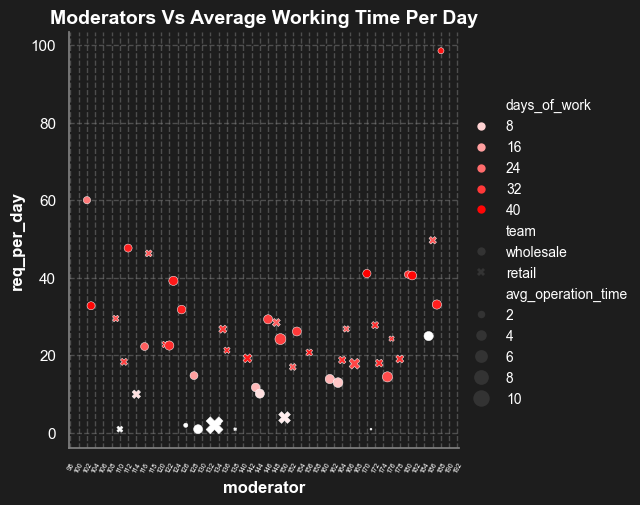

In [23]:
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
sns.relplot(data=moderators_df, x='moderator', y='req_per_day', size='avg_operation_time', sizes=(2, 150), hue='days_of_work', style='team', palette=custom_cmap)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=len(moderators_df['moderator']))) 
plt.gca().tick_params(axis='x',labelrotation=60, labelsize=5)
plt.title('Moderators Vs Average Working Time Per Day')
print(f'Average working time per day: {moderators_df["avg_time_on_work"].mean()}')
plt.show()

Average working time per day: 54.75769446051589


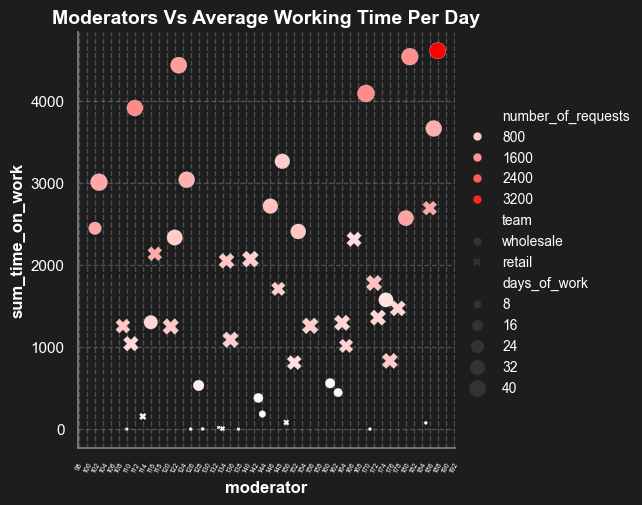

In [24]:
sns.relplot(data=moderators_df, x='moderator', y='sum_time_on_work', size='days_of_work', sizes=(5, 150), hue='number_of_requests', style='team', palette=custom_cmap)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=len(moderators_df['moderator']))) 
plt.gca().tick_params(axis='x',labelrotation=60, labelsize=5)
plt.title('Moderators Vs Average Working Time Per Day')
print(f'Average working time per day: {moderators_df["avg_time_on_work"].mean()}')
plt.show()

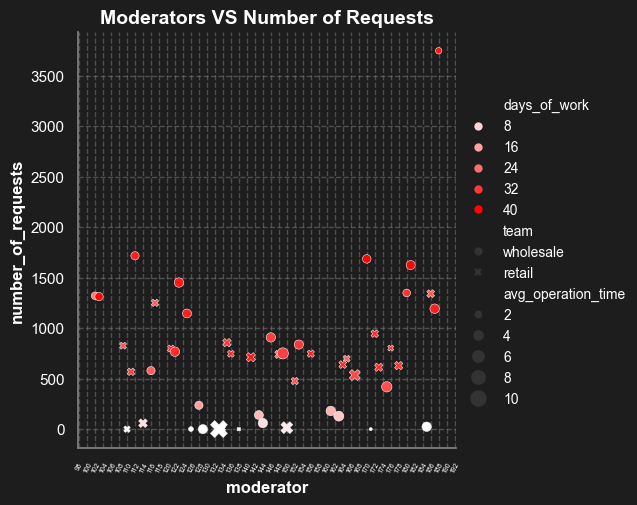

In [25]:
sns.relplot(data=moderators_df,x='moderator',y='number_of_requests', size='avg_operation_time',sizes=(5, 150), hue='days_of_work',style='team', palette=custom_cmap)
plt.title('Moderators VS Number of Requests')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=len(moderators_df['moderator']))) 
plt.gca().tick_params(axis='x',labelrotation=60, labelsize=5)
plt.show()


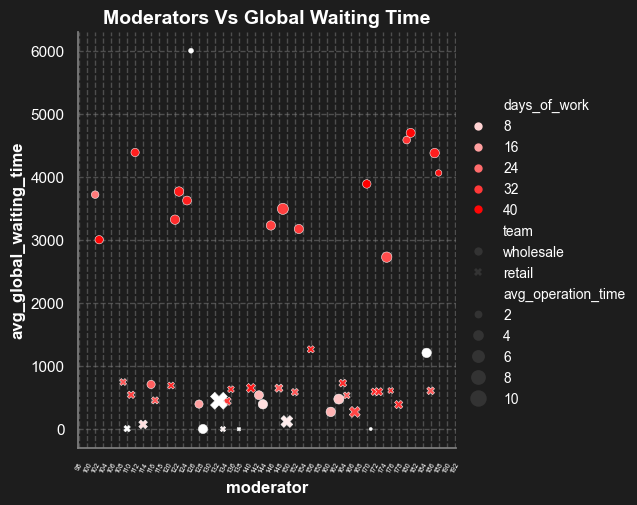

In [26]:
sns.relplot(data=moderators_df,x='moderator',y='avg_global_waiting_time', size='avg_operation_time',sizes=(5, 150), hue='days_of_work',style='team', palette=custom_cmap)
plt.title('Moderators Vs Global Waiting Time')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=len(moderators_df['moderator']))) 
plt.gca().tick_params(axis='x',labelrotation=60, labelsize=5)
plt.show()

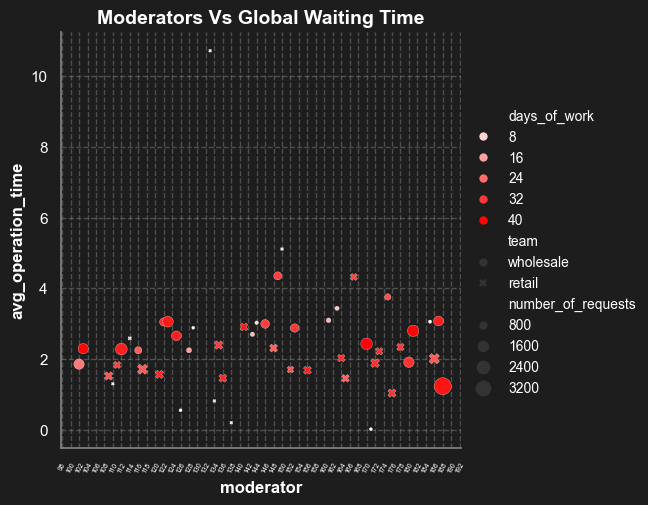

In [36]:
sns.relplot(data=moderators_df,x='moderator',y='avg_operation_time', size='number_of_requests',sizes=(5, 150), hue='days_of_work',style='team', palette=custom_cmap)
plt.title('Moderators Vs Global Waiting Time')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=len(moderators_df['moderator']))) 
plt.gca().tick_params(axis='x',labelrotation=60, labelsize=5)
plt.show()

Average number of done request per retail moderator: 19.747676297066025


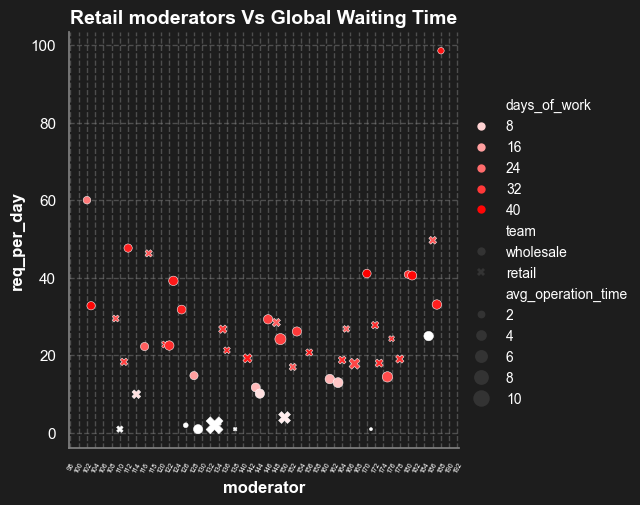

In [27]:
sns.relplot(data=moderators_df, x='moderator', y='req_per_day', size='avg_operation_time', sizes=(5, 150), hue='days_of_work',style='team', palette=custom_cmap)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=len(moderators_df['moderator']))) 
plt.gca().tick_params(axis='x',labelrotation=60, labelsize=5)
plt.title('Retail moderators Vs Global Waiting Time')
print(f'Average number of done request per retail moderator: {moderators_df[moderators_df['team']=='retail']["req_per_day"].mean()}')



Percent of working days by wholesail moderator: 18.135338345864664%


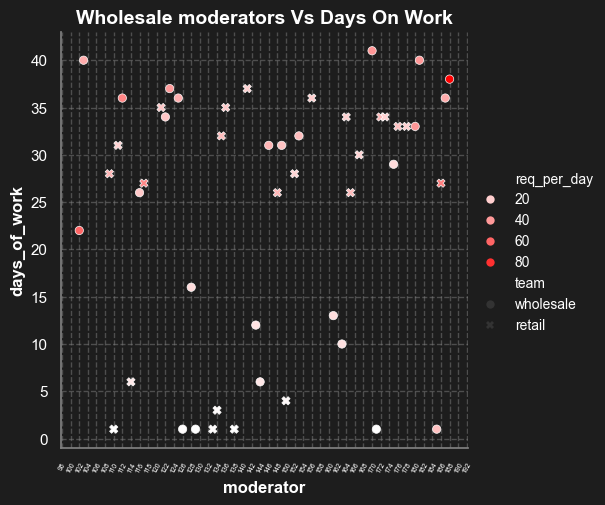

In [28]:
sns.relplot(data=moderators_df, x='moderator', y='days_of_work', style='team',hue='req_per_day',palette=custom_cmap)
plt.title('Wholesale moderators Vs Days On Work')
print(f'Percent of working days by wholesail moderator: {moderators_df[moderators_df['team']=='wholesale']["days_of_work"].mean()/len(daily_stats['date']) * 5/7*100}%')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=len(moderators_df['moderator']))) 
plt.gca().tick_params(axis='x',labelrotation=60, labelsize=5)

plt.show()